# cWGAN
Simula FRBs utilizando o catálogo CHIME para aprendizado.

In [70]:
import os
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

# Carregar CHIME FITS e preparar features/condições
chime_fits_path = 'chimefrbcat1.fits'
with fits.open(chime_fits_path) as hdul:
    data_table = hdul[1].data
df = pd.DataFrame(data_table)

# Colunas de interesse
features_all = [
    'bonsai_snr', 'bonsai_dm', 'width_fitb', 'fluence', 'peak_freq',
    'scat_time', 'flux', 'dm_fitb', 'snr_fitb', 'low_freq', 'high_freq',
    'dm_exc_ne2001', 'dm_exc_ymw16'
]

# Filtrar o DF para só colunas existentes + remover NaNs
features = [c for c in features_all if c in df.columns]
df_clean = df[features].dropna().reset_index(drop=True)

# Escolha das CONDIÇÕES para guiar a geração + simulador
cond_cols = [c for c in ['dm_fitb', 'width_fitb', 'snr_fitb', 'low_freq', 'high_freq'] if c in df_clean.columns]
assert len(cond_cols) >= 3, "Poucas condições encontradas; ajuste cond_cols conforme as colunas do FITS."

# Vetor-alvo “other” (o que o Gerador aprende a prever)
other_cols = [c for c in df_clean.columns if c not in cond_cols]

cond_np = df_clean[cond_cols].to_numpy().astype(np.float32)
other_np = df_clean[other_cols].to_numpy().astype(np.float32)

# Normalizadores separados para cond e other
scaler_cond = MinMaxScaler(feature_range=(-1, 1))
scaler_other = MinMaxScaler(feature_range=(-1, 1))

cond_norm = scaler_cond.fit_transform(cond_np).astype(np.float32)
other_norm = scaler_other.fit_transform(other_np).astype(np.float32)

# Dataset TF
batch_size = 64
latent_dim = 64

def make_dataset():
    ds = tf.data.Dataset.from_tensor_slices((cond_norm, other_norm))
    ds = ds.shuffle(4096).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset()

# Modelos (Gerador G e Crítico D) - versão condicional
# Entrada do Gerador: [z, cond]
# Saída do Gerador: vetor other_norm (mesma dim de other_cols)
# Entrada do Crítico: concat([cond, other]) -> escalar (score)
other_dim = other_norm.shape[1]
cond_dim  = cond_norm.shape[1]

def build_generator(latent_dim:int, cond_dim:int, other_dim:int):
    z_in    = layers.Input(shape=(latent_dim,), dtype=tf.float32, name='z')
    c_in    = layers.Input(shape=(cond_dim,), dtype=tf.float32, name='cond')
    x       = layers.Concatenate()([z_in, c_in])
    x       = layers.Dense(256, activation='relu')(x)
    x       = layers.Dense(256, activation='relu')(x)
    out     = layers.Dense(other_dim, activation='tanh')(x)  # [-1,1]
    return tf.keras.Model([z_in, c_in], out, name='Generator')

def build_critic(cond_dim:int, other_dim:int):
    x_in    = layers.Input(shape=(cond_dim + other_dim,), dtype=tf.float32, name='x')  # concat([cond, other])
    x       = layers.Dense(256, activation='leaky_relu')(x_in)
    x       = layers.Dense(256, activation='leaky_relu')(x)
    score   = layers.Dense(1, activation=None)(x)  # escalar sem ativação
    return tf.keras.Model(x_in, score, name='Critic')

G = build_generator(latent_dim, cond_dim, other_dim)
D = build_critic(cond_dim, other_dim)

# GAN
g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)
d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)

gp_lambda = 10.0             # gradient penalty coef.
n_critic  = 5                # steps do crítico por step do gerador
epochs    = 1000

@tf.function
def gradient_penalty(cond_batch, real_other, fake_other):
    # Interpolação entre real e fake
    alpha = tf.random.uniform([tf.shape(real_other)[0], 1], 0.0, 1.0, dtype=tf.float32)
    inter = alpha * real_other + (1 - alpha) * fake_other
    x_in  = tf.concat([cond_batch, inter], axis=1)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(x_in)
        d_inter = D(x_in, training=True)
    grads = gp_tape.gradient(d_inter, [x_in])[0]
    grads_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((grads_norm - 1.0)**2)
    return gp

@tf.function
def d_train_step(cond_batch, real_other):
    # garantir tipos
    cond_batch = tf.convert_to_tensor(cond_batch, dtype=tf.float32)
    real_other = tf.convert_to_tensor(real_other, dtype=tf.float32)

    z = tf.random.normal([tf.shape(cond_batch)[0], latent_dim], dtype=tf.float32)
    with tf.GradientTape() as tape:
        fake_other = G([z, cond_batch], training=True)
        d_real = D(tf.concat([cond_batch, real_other], axis=1), training=True)
        d_fake = D(tf.concat([cond_batch, fake_other], axis=1), training=True)

        #WGAN critic loss: maximize d_real - d_fake -> minimize (d_fake - d_real)
        d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        gp = gradient_penalty(cond_batch, real_other, fake_other)
        d_total = d_loss + gp_lambda * gp

    grads = tape.gradient(d_total, D.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, D.trainable_variables))
    return d_total, d_loss, gp

@tf.function
def g_train_step(cond_batch):
    cond_batch = tf.convert_to_tensor(cond_batch, dtype=tf.float32)
    z = tf.random.normal([tf.shape(cond_batch)[0], latent_dim], dtype=tf.float32)
    with tf.GradientTape() as tape:
        fake_other = G([z, cond_batch], training=True)
        d_fake = D(tf.concat([cond_batch, fake_other], axis=1), training=True)
        #WGAN generator loss: maximize d_fake -> minimize -d_fake
        g_loss = -tf.reduce_mean(d_fake)
    grads = tape.gradient(g_loss, G.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, G.trainable_variables))
    return g_loss

# Treino
for epoch in range(1, epochs + 1):
    for cond_b, other_b in train_ds:
        # vários passos do crítico
        for _ in range(n_critic):
            d_total, d_loss, gp = d_train_step(cond_b, other_b)
        # um passo do gerador
        g_loss = g_train_step(cond_b)

    if epoch % 100 == 0:
        print(f"[Epoch {epoch:04d}] D_total={d_total.numpy():.4f}  D_loss={d_loss.numpy():.4f}  GP={gp.numpy():.4f}  G_loss={g_loss.numpy():.4f}")

# Simulador de waterfall (freq x tempo) usando condições físicas
def simulate_waterfall(dm, width_ms, snr, f_min, f_max, n_freq=256, n_time=256, sampling_time_ms=1.0):
    # Simula um waterfall sintético (freq x tempo) de um FRB dispersado.
    freqs = np.linspace(f_min, f_max, n_freq)
    k_dm = 4.15e3
    delays_ms = k_dm * dm * (freqs**(-2) - (f_max**(-2)))
    waterfall = np.zeros((n_freq, n_time), dtype=np.float32)
    time_ms = np.arange(n_time) * sampling_time_ms

    # pulso gaussiano em cada canal, centro deslocado pelo atraso de dispersão
    def pulse(t, center, width):
        return np.exp(-0.5 * ((t - center) / width)**2)

    for i, delay in enumerate(delays_ms):
        waterfall[i, :] = pulse(time_ms, delay, width_ms)

    # escala para "snr" (não calibrado fisicamente)
    m = waterfall.max() if waterfall.max() > 0 else 1.0
    waterfall = waterfall * (snr / m)
    return waterfall  # (n_freq, n_time)

# Geração condicional + salvamento FITS com uma ImageHDU por amostra
def generate_and_save_fits_with_waterfalls(
    n_samples:int,
    filename:str = 'synthetic_frbs_with_waterfalls.fits',
    n_freq:int = 256,
    n_time:int = 256
):
    # Amostra condições reais (bootstrap) e normaliza
    idx = np.random.randint(0, cond_np.shape[0], size=n_samples)
    cond_real      = cond_np[idx]                          # escala original (para salvar no FITS)
    cond_real_norm = scaler_cond.transform(cond_real).astype(np.float32)

    # Tensores (corrigindo mistura de tipos)
    z = tf.random.normal([n_samples, latent_dim], dtype=tf.float32)
    cond_real_norm_tf = tf.convert_to_tensor(cond_real_norm, dtype=tf.float32)

    # Gerar 'other' normalizado e reverter à escala original
    other_norm_gen = G([z, cond_real_norm_tf], training=False).numpy()
    other_orig     = scaler_other.inverse_transform(other_norm_gen)

    # Montar DataFrame final com colunas (cond + other)
    gen_df = pd.DataFrame(np.concatenate([cond_real, other_orig], axis=1),
                          columns=cond_cols + other_cols)

    # Criar tabela (BinTableHDU) de parâmetros
    cols = []
    for colname in gen_df.columns:
        arr = gen_df[colname].to_numpy()
        # formato 'D' (float64) no FITS
        cols.append(fits.Column(name=colname, format='D', array=arr))
    table_hdu = fits.BinTableHDU.from_columns(cols)
    table_hdu.name = 'PARAMS'

    # Criar HDUs de imagem (uma por waterfall)
    hdus = [fits.PrimaryHDU(), table_hdu]

    # Gerar cada waterfall a partir das condições físicas da linha
    for i in range(n_samples):
        row = gen_df.iloc[i]
        dm  = float(row.get('dm_fitb', 500.0))
        wms = float(row.get('width_fitb', 5.0))
        snr = float(row.get('snr_fitb', 10.0))
        fmin = float(row.get('low_freq', 400.0))
        fmax = float(row.get('high_freq', 800.0))

        wf = simulate_waterfall(dm=dm, width_ms=wms, snr=snr, f_min=fmin, f_max=fmax,
                                n_freq=n_freq, n_time=n_time)

        img_hdu = fits.ImageHDU(data=wf.astype(np.float32), name=f'WF_{i:04d}')
        # Metadados úteis no header da imagem
        img_hdu.header['DM']      = dm
        img_hdu.header['WIDTHMS'] = wms
        img_hdu.header['SNR']     = snr
        img_hdu.header['FMIN']    = fmin
        img_hdu.header['FMAX']    = fmax
        img_hdu.header['NFREQ']   = n_freq
        img_hdu.header['NTIME']   = n_time
        hdus.append(img_hdu)

    hdul = fits.HDUList(hdus)
    hdul.writeto(filename, overwrite=True)
    print(f">> Arquivo FITS salvo: {filename}")
    return filename, gen_df

# Geração + Salvamento
_ = generate_and_save_fits_with_waterfalls(
    n_samples=1000, 
    filename='synthetic_frbs_with_waterfalls.fits',
    n_freq=256, n_time=256
)

[Epoch 0100] D_total=-0.1711  D_loss=-0.2273  GP=0.0056  G_loss=0.2930


2025-08-19 17:42:25.534232: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch 0200] D_total=-0.1567  D_loss=-0.1826  GP=0.0026  G_loss=0.4187
[Epoch 0300] D_total=-0.1815  D_loss=-0.2116  GP=0.0030  G_loss=0.5018
[Epoch 0400] D_total=-0.1562  D_loss=-0.2029  GP=0.0047  G_loss=0.5935
[Epoch 0500] D_total=-0.1435  D_loss=-0.1686  GP=0.0025  G_loss=0.7959
[Epoch 0600] D_total=-0.1414  D_loss=-0.1677  GP=0.0026  G_loss=0.5759
[Epoch 0700] D_total=-0.1419  D_loss=-0.1649  GP=0.0023  G_loss=0.5372
[Epoch 0800] D_total=-0.1521  D_loss=-0.1824  GP=0.0030  G_loss=0.4130
[Epoch 0900] D_total=-0.1772  D_loss=-0.1968  GP=0.0020  G_loss=0.5346
[Epoch 1000] D_total=-0.1230  D_loss=-0.1457  GP=0.0023  G_loss=0.4548
>> Arquivo FITS salvo: synthetic_frbs_with_waterfalls.fits


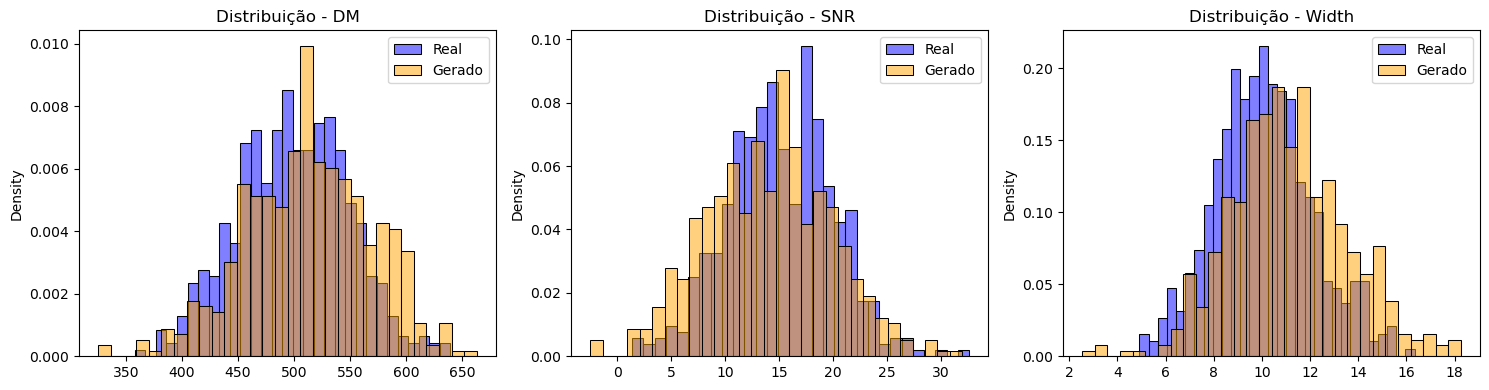

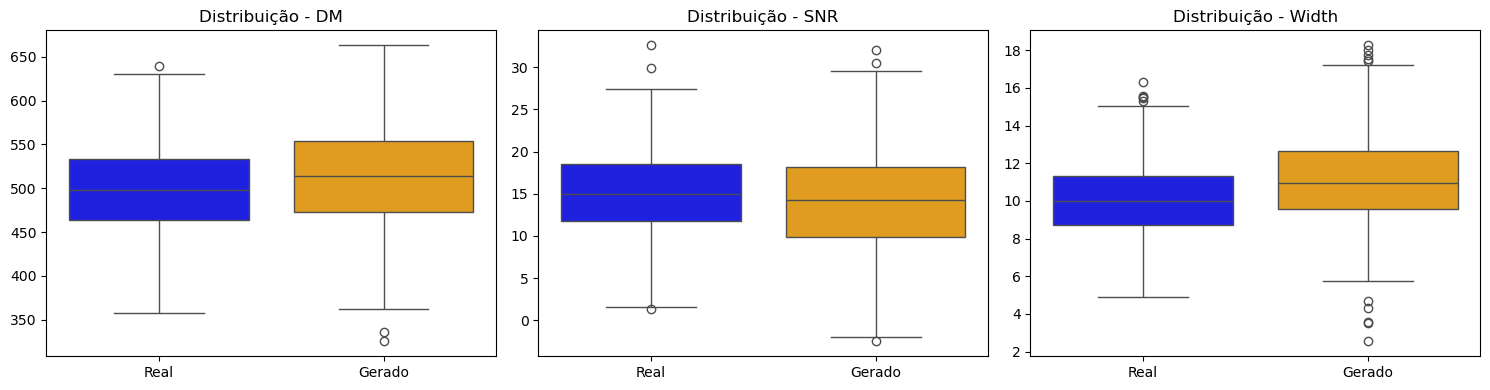

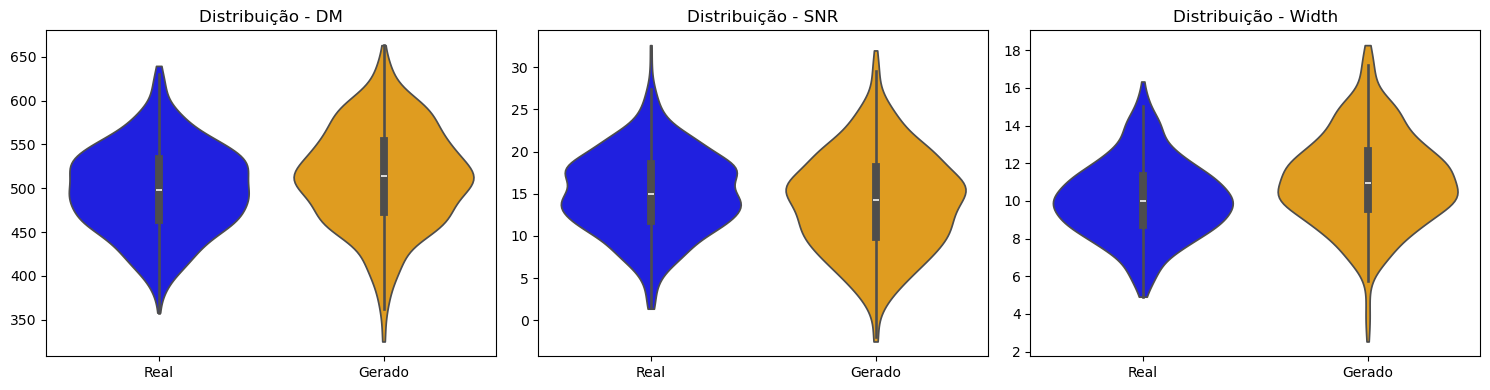

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulando dados reais (exemplo)
real_data = pd.DataFrame({
    "DM": np.random.normal(500, 50, 500),    # medida de dispersão
    "SNR": np.random.normal(15, 5, 500),     # relação sinal-ruído
    "Width": np.random.normal(10, 2, 500)    # largura do pulso
})

# Simulando dados gerados (exemplo)
generated_data = pd.DataFrame({
    "DM": np.random.normal(510, 60, 500),
    "SNR": np.random.normal(14, 6, 500),
    "Width": np.random.normal(11, 2.5, 500)
})


def plot_real_vs_generated(real_data, generated_data, feature_names, 
                           scale='normalized', bins=30, plot_type="hist"):
    """
    Compara distribuições de features entre dados reais e gerados.

    Parameters
    ----------
    real_data : np.ndarray ou pd.DataFrame
        Dados reais, shape (n_samples, n_features).
    generated_data : np.ndarray ou pd.DataFrame
        Dados gerados, shape (n_samples, n_features).
    feature_names : list
        Lista com nomes das features (mesmo número de colunas).
    scale : str, default='normalized'
        Se 'normalized', plota densidade (pdf). Se 'count', plota contagens.
    bins : int, default=30
        Número de bins para os histogramas (se plot_type="hist").
    plot_type : str, default="hist"
        Tipo de plot: "hist" (histogramas), "box" (boxplots), "violin" (violinos).
    """
    real_data = np.asarray(real_data)
    generated_data = np.asarray(generated_data)

    n_features = real_data.shape[1]
    fig, axes = plt.subplots(1, n_features, figsize=(5*n_features, 4))

    if n_features == 1:
        axes = [axes]  # garante lista mesmo com 1 feature

    for i, ax in enumerate(axes):
        if plot_type == "hist":
            if scale == 'normalized':
                sns.histplot(real_data[:, i], bins=bins, stat="density", 
                             color='blue', alpha=0.5, label="Real", ax=ax)
                sns.histplot(generated_data[:, i], bins=bins, stat="density", 
                             color='orange', alpha=0.5, label="Gerado", ax=ax)
            else:
                sns.histplot(real_data[:, i], bins=bins, stat="count", 
                             color='blue', alpha=0.5, label="Real", ax=ax)
                sns.histplot(generated_data[:, i], bins=bins, stat="count", 
                             color='orange', alpha=0.5, label="Gerado", ax=ax)

        elif plot_type == "box":
            sns.boxplot(data=[real_data[:, i], generated_data[:, i]], 
                        ax=ax, palette=["blue", "orange"])
            ax.set_xticks([0,1])
            ax.set_xticklabels(["Real", "Gerado"])

        elif plot_type == "violin":
            sns.violinplot(data=[real_data[:, i], generated_data[:, i]], 
                           ax=ax, palette=["blue", "orange"], cut=0)
            ax.set_xticks([0,1])
            ax.set_xticklabels(["Real", "Gerado"])

        ax.set_title(f"Distribuição - {feature_names[i]}")
        if plot_type == "hist":
            ax.legend()

    plt.tight_layout()
    plt.show()

feature_names = ["DM", "SNR", "Width"]

# Histogramas normalizados
plot_real_vs_generated(real_data, generated_data, feature_names, plot_type="hist", scale="normalized")

# Boxplots
plot_real_vs_generated(real_data, generated_data, feature_names, plot_type="box")

# Violin plots
plot_real_vs_generated(real_data, generated_data, feature_names, plot_type="violin")

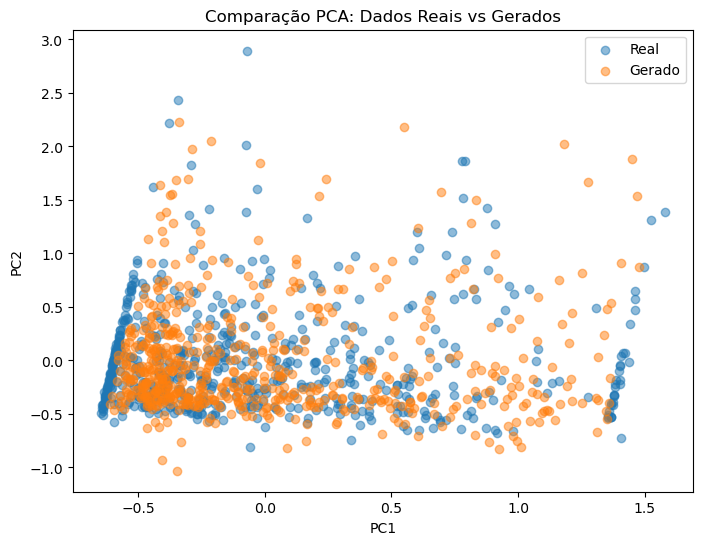

In [73]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


def plot_pca_comparacao(real_data, generator_model, cond_data, latent_dim=64, n_samples=600, n_components=2):
    """
    Plota comparação PCA entre dados reais e dados gerados pela GAN condicional.
    
    real_data       -> array/numpy dos dados reais (other_norm ou dados escalados)
    generator_model -> modelo gerador G da GAN
    cond_data       -> array de condições normatizadas (cond_norm)
    latent_dim      -> dimensão do espaço latente da GAN
    n_samples       -> número de amostras a gerar
    n_components    -> número de componentes principais (2 para plot 2D)
    """
    # Seleciona aleatoriamente condicoes para geração
    idx = np.random.randint(0, cond_data.shape[0], size=n_samples)
    cond_batch = cond_data[idx]

    # Gera ruído latente e amostras do gerador
    z = tf.random.normal([n_samples, latent_dim], dtype=tf.float32)
    generated = generator_model([z, tf.convert_to_tensor(cond_batch, dtype=tf.float32)], training=False).numpy()
    
    # PCA conjunta
    combined = np.vstack([real_data, generated])
    pca_result = PCA(n_components=n_components).fit_transform(combined)

    n_real = real_data.shape[0]

    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(pca_result[:n_real, 0], pca_result[:n_real, 1], label='Real', alpha=0.5)
    plt.scatter(pca_result[n_real:, 0], pca_result[n_real:, 1], label='Gerado', alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Comparação PCA: Dados Reais vs Gerados')
    plt.legend()
    plt.show()

# Número de amostras
n_samples_plot = 600

plot_pca_comparacao(
    real_data = other_norm[:600],  # dados reais
    generator_model = G,
    cond_data = cond_norm,
    latent_dim = 64,               # deve ser o mesmo do G
    n_samples = 600,
    n_components = 2
)


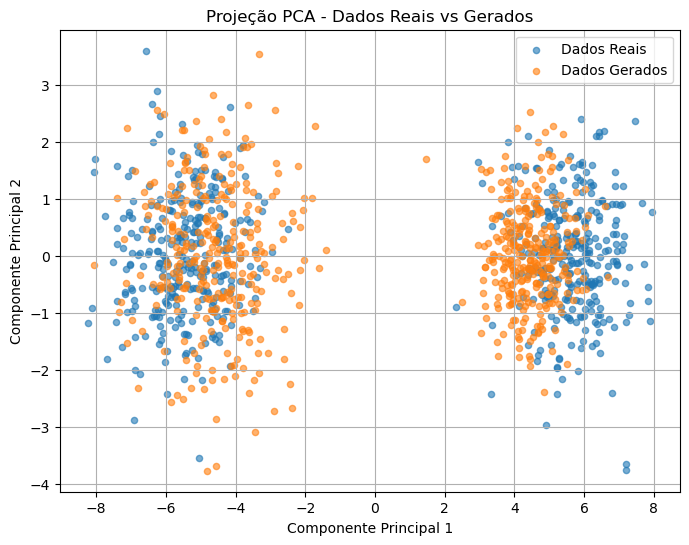

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dados reais: 2 distribuições gaussianas juntas
np.random.seed(42)
real_data_part1 = np.random.normal(loc=0, scale=1, size=(300, 5))
real_data_part2 = np.random.normal(loc=5, scale=1, size=(300, 5))
real_data = np.vstack([real_data_part1, real_data_part2])

# Dados gerados: tentam imitar a distribuição real, mas com alguma diferença
generated_data_part1 = np.random.normal(loc=0.5, scale=1.2, size=(300, 5))
generated_data_part2 = np.random.normal(loc=4.5, scale=0.8, size=(300, 5))
generated_data = np.vstack([generated_data_part1, generated_data_part2])

# Aplicar PCA com 2 componentes principais
pca = PCA(n_components=2)
pca.fit(np.vstack([real_data, generated_data]))

real_proj = pca.transform(real_data)
gen_proj = pca.transform(generated_data)

# Plotar
plt.figure(figsize=(8,6))
plt.scatter(real_proj[:,0], real_proj[:,1], label='Dados Reais', alpha=0.6, s=20)
plt.scatter(gen_proj[:,0], gen_proj[:,1], label='Dados Gerados', alpha=0.6, s=20)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção PCA - Dados Reais vs Gerados')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd

# Mostrando o conteúdo do FITS
def visualizar_tabela_fits(fits_path):
    with fits.open(fits_path) as hdul:
        hdul.info()
        
        # Tentar encontrar uma tabela em alguma extensão (geralmente HDU[1])
        for hdu in hdul:
            if isinstance(hdu, fits.BinTableHDU) or isinstance(hdu, fits.TableHDU):
                table = Table(hdu.data)
                df = table.to_pandas()
                print("\nTabela encontrada:")
                print(df.head())  # Mostra as 5 primeiras linhas
                return df

        print("Nenhuma tabela foi encontrada neste arquivo FITS.")
        return None

caminho_arquivo = "synthetic_frbs.fits"
visualizar_tabela_fits(caminho_arquivo)

Filename: synthetic_frbs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     34   600R x 13C   [D, D, D, D, D, D, D, D, D, D, D, D, D]   

Tabela encontrada:
   bonsai_snr    bonsai_dm  width_fitb    fluence   peak_freq  scat_time  \
0    9.488028   239.163651    0.003371   8.651882  467.036438   0.062815   
1   16.574997   303.166931    0.007359   8.625594  442.017517   0.018175   
2   21.628813   470.186523    0.004888  19.459867  684.611816   0.016077   
3  103.025742   973.316162    0.000121  25.419811  453.626526   0.000106   
4   10.831430  1014.739014    0.001905   3.931614  550.629211   0.002015   

       flux      dm_fitb    snr_fitb    low_freq   high_freq  dm_exc_ne2001  \
0  0.000057   253.962585   25.634939  400.200012  799.880554     123.175568   
1  0.502127   274.756226   26.969183  400.211304  560.554077     118.925224   
2  0.908104   387.282104   37.728626  556.770

,bonsai_snr,bonsai_dm,width_fitb,fluence,peak_freq,scat_time,flux,dm_fitb,snr_fitb,low_freq,high_freq,dm_exc_ne2001,dm_exc_ymw16
0,9.488028,239.163651,0.003371,8.651882,467.036438,0.062815,0.000057,253.962585,25.634939,400.200012,799.880554,123.175568,68.455063
1,16.574997,303.166931,0.007359,8.625594,442.017517,0.018175,0.502127,274.756226,26.969183,400.211304,560.554077,118.925224,84.503166
2,21.628813,470.186523,0.004888,19.459867,684.611816,0.016077,0.908104,387.282104,37.728626,556.770203,791.774719,378.672821,390.354279
3,103.025742,973.316162,0.000121,25.419811,453.626526,0.000106,4.300909,1038.384277,132.106598,400.200012,800.199768,794.332642,718.652893
4,10.831430,1014.739014,0.001905,3.931614,550.629211,0.002015,0.487820,983.555725,12.694879,400.200012,800.200012,931.545105,939.194214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,39.836815,221.228760,0.000237,8.864444,555.420349,0.000288,6.744508,232.173477,102.576164,400.820404,760.700989,110.799843,52.137096
596,23.904718,1111.609375,0.000441,1.366172,576.038757,0.000218,1.984421,1085.354614,72.738274,400.200012,800.200012,1104.870361,1084.184937
597,14.736146,2059.968018,0.000481,2.986190,481.317719,0.001328,1.095753,2053.882812,22.257698,400.200073,800.190552,1990.520752,2025.108154
598,11.221047,910.004883,0.000846,2.505415,400.300842,0.001467,0.756532,953.610107,13.797112,400.200012,716.589539,926.913330,878.366516


# MLP
### Pra ler uma tabela FITS sem imagem

Pesos usados na loss: {np.int64(0): np.float64(0.5833333333333334), np.int64(1): np.float64(3.5)}
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.4421 - val_accuracy: 1.0000 - val_loss: 0.0180
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 5.2830e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 2.6632e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 7.9704e-04 - val_accuracy: 1.0000 - val_loss: 1.4917e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 8.6503e-04 - val_accuracy: 1.0000 - val_loss: 9.6601e-05
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 6.0678e-04 - val_accuracy: 1.0000 - val_loss:

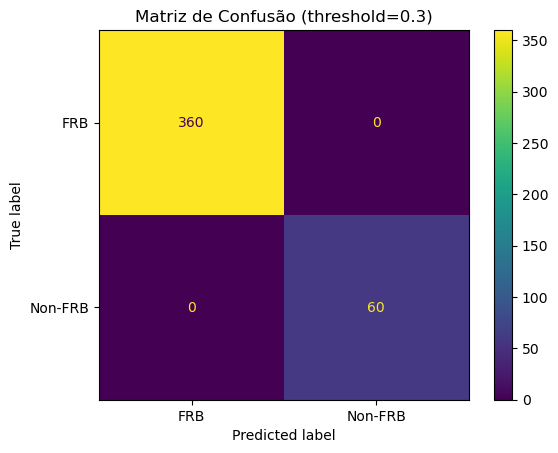

              precision    recall  f1-score   support

         FRB       1.00      1.00      1.00       360
     Non-FRB       1.00      1.00      1.00        60

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



In [85]:
import numpy as np
import pandas as pd
from astropy.io import fits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Função para carregar FITS 
def carregar_dados_fits_tabular(fits_path, label=None):
    with fits.open(fits_path) as hdul:
        dados = hdul[1].data
        df = pd.DataFrame(np.array(dados).byteswap().view(dados.dtype.newbyteorder('=')))
    # Mantém apenas colunas numéricas
    df = df.select_dtypes(include=[np.number]).dropna(axis=1, how="any")
    X = df.values
    y = np.array([label]*len(df)) if label is not None else None
    return X, y

# Função para aumento de dados numéricos
def aumentar_dados(X, y, fator=2, intensidade=0.01):
    X_aumentado = []
    y_aumentado = []
    for i in range(len(X)):
        X_aumentado.append(X[i])
        y_aumentado.append(y[i])
        for _ in range(fator-1):
            ruido = np.random.normal(0, intensidade, size=X[i].shape)
            X_aumentado.append(X[i] + ruido)
            y_aumentado.append(y[i])
    return np.array(X_aumentado), np.array(y_aumentado)

# Carregar CHIME com aumento de dados
X_chime, y_chime = carregar_dados_fits_tabular("chimefrbcat1.fits", label=0)
X_chime, y_chime = aumentar_dados(X_chime, y_chime, fator=3)

# Carregar Non-FRB simulados (sem aumento de dados)
X_nonfrb, y_nonfrb = carregar_dados_fits_tabular("nonfrb_synthetic.fits", label=1)

# Manter apenas colunas comuns entre os dois datasets
colunas_chime = pd.DataFrame(X_chime).columns
colunas_nonfrb = pd.DataFrame(X_nonfrb).columns
colunas_comuns = colunas_chime.intersection(colunas_nonfrb)

X_chime = pd.DataFrame(X_chime)[colunas_comuns].values
X_nonfrb = pd.DataFrame(X_nonfrb)[colunas_comuns].values

# Combinar datasets
X_total = np.vstack([X_chime, X_nonfrb])
y_total = np.concatenate([y_chime, y_nonfrb])

# Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42, stratify=y_total
)

# Normalização 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Pesos para lidar com desbalanceamento 
pesos = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
pesos_dict = dict(zip(np.unique(y_train), pesos))
print("Pesos usados na loss:", pesos_dict)

# Modelo MLP 
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=pesos_dict)

# Predição com threshold customizado 
y_pred_prob = model.predict(X_test).flatten()
threshold = 0.3  # ajuste para balancear recall/precision
y_pred = (y_pred_prob >= threshold).astype(int)

# Avaliação 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FRB', 'Non-FRB'])
disp.plot()
plt.title(f"Matriz de Confusão (threshold={threshold})")
plt.show()

print(classification_report(y_test, y_pred, target_names=['FRB', 'Non-FRB']))

In [ ]:
'''
import matplotlib.pyplot as plt

# Histograma das probabilidades preditas por classe real
plt.figure(figsize=(8, 5))
plt.hist(y_pred_prob[y_test == 0], bins=30, alpha=0.6, label='FRB (classe 0)', color='blue')
plt.hist(y_pred_prob[y_test == 1], bins=30, alpha=0.6, label='Non-FRB (classe 1)', color='red')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold 0.5')
plt.axvline(0.3, color='green', linestyle='--', label='Threshold 0.3')
plt.xlabel("Probabilidade prevista (classe 1)")
plt.ylabel("Frequência")
plt.title("Distribuição de probabilidades previstas por classe real")
plt.legend()
plt.show()
'''

### Curva ROC e da curva Precision-Recall

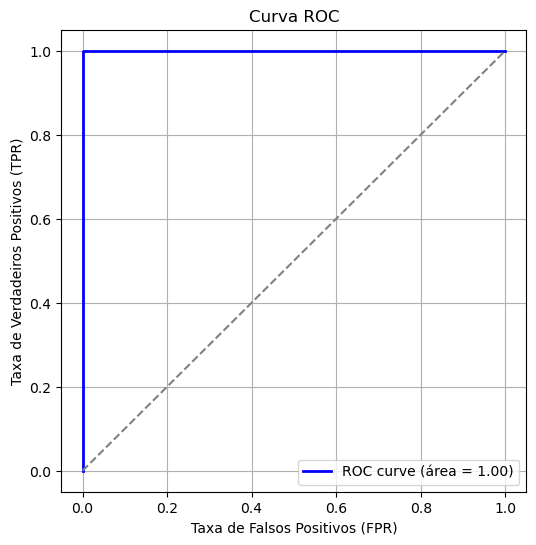

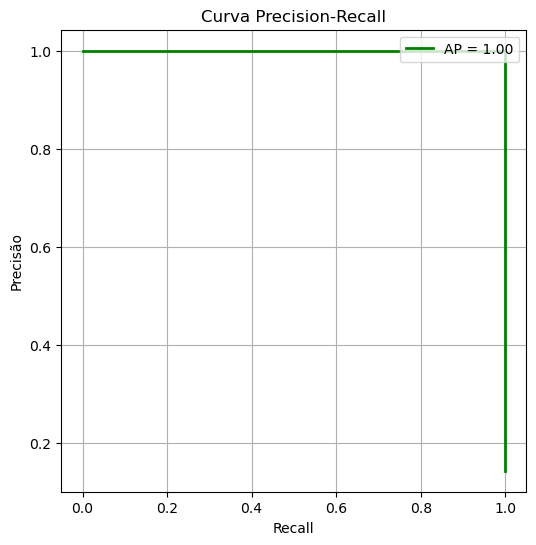

In [88]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [89]:
from sklearn.metrics import confusion_matrix, classification_report

# Cálculo do threshold ótimo (Youden's J) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
youden_index = tpr - fpr
best_threshold = thresholds[youden_index.argmax()]

print(f"Threshold ótimo (Youden's J): {best_threshold:.3f}")

# Reclassificação usando o novo threshold
y_pred_best = (y_pred_prob >= best_threshold).astype(int)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_best)
print("\nMatriz de confusão com threshold ótimo:")
print(cm)

# Relatório de métricas
print("\nRelatório de classificação com threshold ótimo:")
print(classification_report(y_test, y_pred_best, digits=2))

Threshold ótimo (Youden's J): 1.000

Matriz de confusão com threshold ótimo:
[[360   0]
 [  0  60]]

Relatório de classificação com threshold ótimo:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00        60

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



# CNN

Pesos calculados para as classes: {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/50


/Users/rafas/opt/anaconda3/envs/tf_py310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5232 - loss: 0.9048 - val_accuracy: 0.5911 - val_loss: 0.6486
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7299 - loss: 0.6055 - val_accuracy: 0.5026 - val_loss: 0.6492
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7819 - loss: 0.5295 - val_accuracy: 0.5104 - val_loss: 0.6591
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.4516 - val_accuracy: 0.5521 - val_loss: 0.6311
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8251 - loss: 0.4576 - val_accuracy: 0.6432 - val_loss: 0.5699
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8233 - loss: 0.4627 - val_accuracy: 0.7109 - val_loss: 0.4940
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8430 - loss: 0.3832 - val_accuracy: 0.7943 - val_loss: 0.4165
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.3596 - val_accuracy: 0.8411 - val_loss: 0.3516
Epo

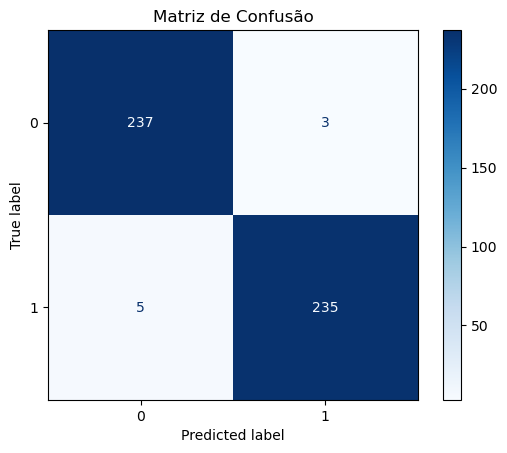

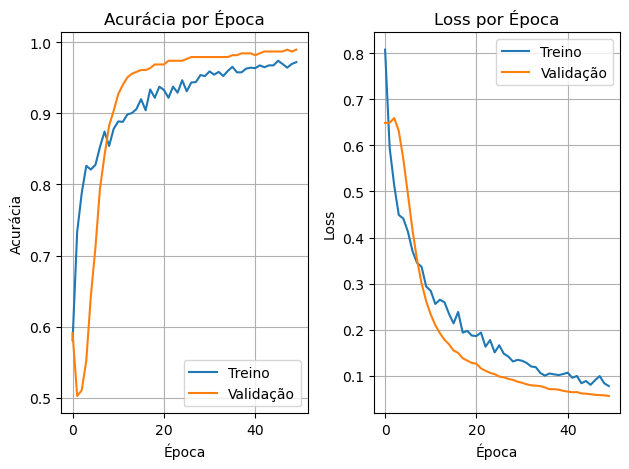

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


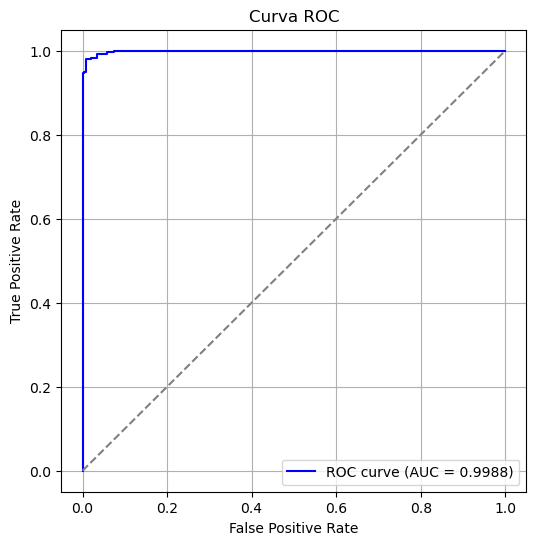

Modelo salvo em: cnn_frb_model.h5


In [77]:
# CNN 1D para FRB com CHIME + GAN
import numpy as np
import pandas as pd
from astropy.io import fits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Função para carregar FITS tabular
def carregar_fits_tabular(fits_path, colunas_referencia=None, label=1):
    with fits.open(fits_path) as hdul:
        data = hdul[1].data
        arr = np.array(data).byteswap().view(data.dtype.newbyteorder('='))
        df = pd.DataFrame(arr)
    # Seleciona colunas existentes
    if colunas_referencia is not None:
        colunas_comuns = [c for c in colunas_referencia if c in df.columns]
        df = df[colunas_comuns]
    else:
        colunas_comuns = list(df.columns)
    df = df.dropna()
    labels = np.full(len(df), label)
    return df, labels, colunas_comuns

# Colunas desejadas
colunas_usadas = [
    'gl', 'gb', 'bonsai_snr', 'bonsai_dm', 'snr_fitb', 'dm_fitb', 'dm_fitb_err',
    'flux', 'flux_err', 'fluence', 'fluence_err', 'width_fitb', 'width_fitb_err',
    'sub_num', 'mjd_400', 'width_fitb_up_lim', 'chi_sq', 'dof'
]

# Carregar FRBs reais (CHIME)
df_real, y_real, colunas_comuns = carregar_fits_tabular("chimefrbcat1.fits", colunas_usadas, label=1)

# Carregar FRBs sintéticos (GAN)
df_synth, y_synth, _ = carregar_fits_tabular("synthetic_frbs.fits", colunas_comuns, label=1)

# Concatenar FRBs reais e sintéticos
X_frb = pd.concat([df_real, df_synth], ignore_index=True)
y_frb = np.concatenate([y_real, y_synth], axis=0)

# Gerar Não-FRBs sintéticos
num_nonfrbs = len(X_frb)
X_nonfrb = np.random.normal(
    X_frb.mean(axis=0),
    X_frb.std(axis=0),
    size=(num_nonfrbs, X_frb.shape[1])
)
y_nonfrb = np.zeros(num_nonfrbs)

# Concatenar todos os dados
X = np.concatenate([X_frb.values, X_nonfrb], axis=0)
y = np.concatenate([y_frb, y_nonfrb], axis=0)

# Padronizar features e tratar NaNs/Inf
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X = X[..., np.newaxis]  # shape = (n_samples, n_features, 1) para Conv1D

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pesos de classes
weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos calculados para as classes:", class_weights)

# Construir CNN 1D
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# Treinar CNN
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Avaliação
loss, acc = model.evaluate(X_test, y_test)
print(f"\nAcurácia no teste: {acc:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Gráficos de Loss e Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Curva ROC e AUC
y_prob = model.predict(X_test).ravel()
y_prob = np.nan_to_num(y_prob, nan=0.0, posinf=1.0, neginf=0.0)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Funções para salvar, carregar e prever
def salvar_modelo(model, caminho="cnn_frb_model.h5"):
    model.save(caminho)
    print(f"Modelo salvo em: {caminho}")

def carregar_modelo(caminho="cnn_frb_model.h5"):
    model = load_model(caminho)
    print(f"Modelo carregado de: {caminho}")
    return model

def prever_frb(model, X_novos, scaler=None):
    if scaler:
        X_novos = scaler.transform(X_novos)
    X_novos = np.nan_to_num(X_novos, nan=0.0, posinf=0.0, neginf=0.0)
    X_novos = X_novos[..., np.newaxis]
    y_prob = model.predict(X_novos).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    return y_pred, y_prob

salvar_modelo(model)
# modelo_carregado = carregar_modelo("cnn_frb_model.h5")
# y_pred_novos, y_prob_novos = prever_frb(modelo_carregado, X_test.squeeze(), scaler=scaler)


# Gerando séries temporais a partir do CHIME e da GAN

Séries temporais para o CHIME

In [83]:
import numpy as np
import pandas as pd
from astropy.io import fits

def generate_chime_timeseries_v2(
    chime_fits_path: str = 'chimefrbcat1.fits',
    n_bins: int = 256,
    sampling_time_ms: float = 1.0,
    output_fits: str = "chime_timeseries_v2.fits"
):
    """
    Gera séries temporais a partir do catálogo CHIME e salva em FITS com nova estrutura.
    
    Args:
        chime_fits_path: caminho para o catálogo CHIME (padrão: 'chimefrbcat1.fits')
        n_bins: número de bins da série temporal
        sampling_time_ms: passo temporal em ms
        output_fits: nome do arquivo FITS de saída
    """
    # Carregar dados do CHIME
    print(f"Lendo catálogo CHIME: {chime_fits_path}")
    try:
        with fits.open(chime_fits_path) as hdul:
            # Verificar estrutura do arquivo CHIME
            if len(hdul) > 1:
                table = hdul[1].data  # Dados geralmente estão no HDU 1
            else:
                table = hdul[0].data  # Ou no HDU 0
                
            df = pd.DataFrame(table)
    except FileNotFoundError:
        print(f"Arquivo CHIME não encontrado: {chime_fits_path}")
        raise
    except Exception as e:
        print(f"Erro ao ler arquivo CHIME: {e}")
        raise
    
    print(f"Carregado catálogo CHIME com {len(df)} entradas")
    
    # Selecionar colunas relevantes e remover NaNs
    cols_cond = [c for c in ['dm_fitb', 'width_fitb', 'snr_fitb', 'low_freq', 'high_freq'] if c in df.columns]
    
    if not cols_cond:
        print("Colunas padrão não encontradas. Usando todas as colunas numéricas...")
        cols_cond = df.select_dtypes(include=[np.number]).columns.tolist()
    
    df = df.dropna(subset=cols_cond).reset_index(drop=True)
    
    n_samples = len(df)
    print(f"{n_samples} amostras após remoção de NaNs")
    
    # Gerar séries temporais
    series_list = []
    series_names = []
    time_bins = np.arange(n_bins) * sampling_time_ms
    
    # Função pulso gaussiano
    def pulse(t, center, width):
        return np.exp(-0.5 * ((t - center) / width) ** 2)
    
    k_dm = 4.15e3  # Constante de dispersão
    
    for i, row in df.iterrows():
        try:
            dm = float(row.get('dm_fitb', 500.0))
            width_ms = float(row.get('width_fitb', 5.0))
            snr = float(row.get('snr_fitb', 10.0))
            f_min = float(row.get('low_freq', 400.0))
            f_max = float(row.get('high_freq', 800.0))
            
            # Atraso de dispersão médio para simulação 1D
            center = k_dm * dm * (f_min**-2 - f_max**-2)  # centro do pulso em ms
            
            # Gerar série temporal
            ts = pulse(time_bins, center, width_ms) * snr
            
            # Adicionar ruído gaussiano para maior realismo
            noise = np.random.normal(0, 0.1, n_bins)
            ts += noise
            
            series_list.append(ts)
            series_names.append(f'CHIME_{i:04d}')
            
        except Exception as e:
            print(f"Erro na linha {i}: {e}")
            continue
    
    if not series_list:
        raise ValueError("Nenhuma série temporal foi gerada!")
    
    # Converter para arrays numpy
    series_array = np.array(series_list, dtype=np.float32)
    series_matrix = series_array  # Backup para HDU de imagem
    
    # Criar HDU da tabela com estrutura padronizada
    param_arrays = []
    
    # Adicionar colunas de parâmetros
    for col in cols_cond:
        if col in df.columns:
            param_arrays.append(
                fits.Column(name=col, format='D', array=df[col].to_numpy())
            )
    
    # Coluna com nomes das séries
    param_arrays.append(
        fits.Column(name='SERIES_NAME', format='20A', array=np.array(series_names, dtype='S20'))
    )
    
    # Coluna com as séries temporais
    param_arrays.append(
        fits.Column(name='TIMESERIES', format=f'{n_bins}E', array=series_array)
    )
    
    # Criar a tabela
    table_hdu = fits.BinTableHDU.from_columns(param_arrays)
    table_hdu.name = 'FRB_PARAMS'
    
    # Criar HDU com matriz 2D (backup)
    series_hdu = fits.ImageHDU(data=series_matrix, name='TIMESERIES_MATRIX')
    
    # HDU final
    hdus = [fits.PrimaryHDU(), table_hdu, series_hdu]
    fits.HDUList(hdus).writeto(output_fits, overwrite=True)
    
    print(f"Séries temporais CHIME salvas em: {output_fits}")
    print(f"Estrutura: {n_samples} séries × {n_bins} pontos temporais")
    print(f"Parâmetros incluídos: {', '.join(cols_cond)}")
    
    return output_fits, df, series_array

def load_chime_timeseries_v2(fits_file):
    """
    Carrega dados do arquivo FITS CHIME com nova estrutura
    """
    with fits.open(fits_file) as hdul:
        if 'FRB_PARAMS' not in hdul:
            raise ValueError("Tabela 'FRB_PARAMS' não encontrada")
        
        table_data = hdul['FRB_PARAMS'].data
        
        # Extrair parâmetros
        param_cols = [col.name for col in hdul['FRB_PARAMS'].columns 
                     if col.name not in ['TIMESERIES', 'SERIES_NAME']]
        params_df = pd.DataFrame({col: table_data[col] for col in param_cols})
        
        # Extrair séries temporais
        series_data = table_data['TIMESERIES']
        series_names = table_data['SERIES_NAME']
        
        # Extrair matriz backup
        if 'TIMESERIES_MATRIX' in hdul:
            series_matrix = hdul['TIMESERIES_MATRIX'].data
        else:
            series_matrix = np.vstack(series_data)
    
    return params_df, series_data, series_names, series_matrix

## Séries temporais para a GAN

In [79]:
from astropy.io import fits
import numpy as np
import pandas as pd

def generate_and_save_fits_with_timeseries(
    n_samples: int,
    filename: str = 'synthetic_frbs_timeseries.fits',
    n_time: int = 256
):
    """
    Gera séries temporais a partir da GAN e salva em FITS com nova estrutura.
    
    Nova estrutura:
    - HDU 0: PrimaryHDU (vazio)
    - HDU 1: BinTableHDU com parâmetros + coluna TIMESERIES contendo arrays
    - HDU 2: ImageHDU com matriz 2D de todas as séries (backup)
    """
    # Amostra condições reais
    idx = np.random.randint(0, cond_np.shape[0], size=n_samples)
    cond_real = cond_np[idx]
    cond_real_norm = scaler_cond.transform(cond_real).astype(np.float32)

    # Ruído latente e geração
    z = tf.random.normal([n_samples, latent_dim], dtype=tf.float32)
    cond_real_norm_tf = tf.convert_to_tensor(cond_real_norm, dtype=tf.float32)
    other_norm_gen = G([z, cond_real_norm_tf], training=False).numpy()
    other_orig = scaler_other.inverse_transform(other_norm_gen)

    # DataFrame com colunas (cond + other)
    gen_df = pd.DataFrame(np.concatenate([cond_real, other_orig], axis=1),
                          columns=cond_cols + other_cols)

    # Gera séries temporais
    series_list = []
    series_names = []
    
    for i in range(n_samples):
        row = gen_df.iloc[i]
        ts = simulate_timeseries(
            dm=float(row.get('dm_fitb', 500.0)),
            width_ms=float(row.get('width_fitb', 5.0)),
            snr=float(row.get('snr_fitb', 10.0)),
            f_min=float(row.get('low_freq', 400.0)),
            f_max=float(row.get('high_freq', 800.0)),
            n_time=n_time,
            method="sum"
        )
        series_list.append(ts)
        series_names.append(f'TS_{i:04d}')

    # Transformar em matriz 2D
    series_array = np.vstack(series_list).astype(np.float32)

    # Criar HDU da tabela com parâmetros + séries
    # Primeiro, criar arrays para cada coluna
    param_arrays = []
    
    # Colunas dos parâmetros
    for col in gen_df.columns:
        param_arrays.append(
            fits.Column(name=col, format='D', array=gen_df[col].to_numpy())
        )
    
    # Coluna com nomes das séries
    param_arrays.append(
        fits.Column(name='SERIES_NAME', format='20A', array=np.array(series_names, dtype='S20'))
    )
    
    # Coluna com as séries temporais (cada elemento é um array 1D)
    param_arrays.append(
        fits.Column(name='TIMESERIES', format=f'{n_time}E', array=np.array(series_list))
    )
    
    # Criar a tabela
    table_hdu = fits.BinTableHDU.from_columns(param_arrays)
    table_hdu.name = 'FRB_PARAMS'

    # HDU com matriz 2D (backup)
    series_hdu = fits.ImageHDU(data=series_array, name='TIMESERIES_MATRIX')

    # HDU final
    hdus = [fits.PrimaryHDU(), table_hdu, series_hdu]
    fits.HDUList(hdus).writeto(filename, overwrite=True)

    print(f">> Séries temporais salvas em nova estrutura: {filename}")
    print(f">> Tabela com {len(gen_df.columns)} parâmetros + série temporal para cada FRB")
    return filename, gen_df

# Função auxiliar para carregar os dados da nova estrutura
def load_frb_timeseries_v2(fits_file):
    """
    Carrega dados do arquivo FITS com nova estrutura
    """
    with fits.open(fits_file) as hdul:
        # Carrega a tabela
        table_data = hdul['FRB_PARAMS'].data
        
        # Extrai parâmetros
        param_cols = [col.name for col in hdul['FRB_PARAMS'].columns 
                     if col.name not in ['TIMESERIES', 'SERIES_NAME']]
        params_df = pd.DataFrame({col: table_data[col] for col in param_cols})
        
        # Extrai séries temporais
        series_data = table_data['TIMESERIES']
        series_names = table_data['SERIES_NAME']
        
        # Extrai matriz backup (opcional)
        if 'TIMESERIES_MATRIX' in hdul:
            series_matrix = hdul['TIMESERIES_MATRIX'].data
        else:
            series_matrix = np.vstack(series_data)
    
    return params_df, series_data, series_names, series_matrix

# Função de carregamento para a LSTM
def load_and_prepare_data_v2(fits_file, test_size=0.2, val_size=0.1):
    """
    Carrega dados do arquivo FITS com nova estrutura para treinamento LSTM
    """
    print("Carregando dados da nova estrutura FITS...")
    
    # Carrega os dados
    params_df, series_data, series_names, series_matrix = load_frb_timeseries_v2(fits_file)
    
    print(f"Encontradas {len(series_data)} séries temporais")
    print(f"Comprimento de cada série: {len(series_data[0])}")
    
    # Converte para array numpy
    series_array = np.array(series_data)
    
    # Normalizar cada série temporal individualmente
    X_normalized = np.zeros_like(series_array)
    for i in range(series_array.shape[0]):
        series = series_array[i]
        if np.std(series) > 0:
            X_normalized[i] = (series - np.mean(series)) / np.std(series)
        else:
            X_normalized[i] = series
    
    # Reshape para LSTM: (samples, time_steps, features)
    X = X_normalized.reshape(X_normalized.shape[0], X_normalized.shape[1], 1)
    
    # Labels (todas são FRBs - 1)
    y = np.ones(X.shape[0])
    
    # Split dos dados
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), 
        random_state=42, stratify=y_temp
    )
    
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    print(f"Test shape: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Função para inspecionar a nova estrutura
def inspect_new_fits_structure(filename):
    """Inspeciona a estrutura do novo arquivo FITS"""
    with fits.open(filename) as hdul:
        print(f"Arquivo: {filename}")
        print(f"Número de HDUs: {len(hdul)}")
        print("\nExtensões disponíveis:")
        for i, hdu in enumerate(hdul):
            data_info = 'No data'
            if hasattr(hdu, 'data') and hdu.data is not None:
                try:
                    if hasattr(hdu.data, 'shape'):
                        data_info = f'Shape: {hdu.data.shape}'
                    else:
                        data_info = f'Table with {len(hdu.data)} rows'
                except Exception as e:
                    data_info = f'Error: {str(e)}'
            print(f"  HDU {i}: Name='{hdu.name}' - Type={type(hdu).__name__} - {data_info}")
        
        # Detalhes da tabela
        if 'FRB_PARAMS' in hdul:
            print(f"\nColunas na tabela FRB_PARAMS:")
            for col in hdul['FRB_PARAMS'].columns:
                print(f"  - {col.name}: {col.format}")

# Exemplo de uso completo:
def complete_pipeline():
    """
    Pipeline completo com nova estrutura
    """
    # 1. Gerar dados com nova estrutura
    print("GERANDO DADOS COM NOVA ESTRUTURA")
    filename, gen_df = generate_and_save_fits_with_timeseries_v2(
        n_samples=1000,
        filename='synthetic_frbs_timeseries_v2.fits',
        n_time=256
    )
    
    # 2. Inspecionar nova estrutura
    print("\nINSPECIONANDO NOVA ESTRUTURA")
    inspect_new_fits_structure(filename)
    
    # 3. Treinar classificador
    print("\nTREINANDO CLASSIFICADOR")
    classifier, history = train_frb_classifier_v2(filename, n_negative_samples=1000)
    
    return classifier, history, gen_df

def train_frb_classifier(fits_file, n_negative_samples=1000):
    """
    Versão do classificador para nova estrutura
    """
    # Carregar dados da nova estrutura
    X_train_pos, X_val_pos, X_test_pos, y_train_pos, y_val_pos, y_test_pos = load_and_prepare_data_v2(fits_file)
    
    # Resto do código permanece igual...
    X_neg = create_negative_samples(n_negative_samples, X_train_pos.shape[1])
    y_neg = np.zeros(X_neg.shape[0])
    
    # Combinar dados
    X_train = np.concatenate([X_train_pos, X_neg[:len(X_train_pos)]], axis=0)
    y_train = np.concatenate([y_train_pos, y_neg[:len(y_train_pos)]], axis=0)
    
    X_val = np.concatenate([X_val_pos, X_neg[len(X_train_pos):len(X_train_pos)+len(X_val_pos)]], axis=0)
    y_val = np.concatenate([y_val_pos, y_neg[len(X_train_pos):len(X_train_pos)+len(X_val_pos)]], axis=0)
    
    X_test = np.concatenate([X_test_pos, X_neg[len(X_train_pos)+len(X_val_pos):]], axis=0)
    y_test = np.concatenate([y_test_pos, y_neg[len(X_train_pos)+len(X_val_pos):]], axis=0)
    
    # Embaralhar
    train_indices = np.random.permutation(len(X_train))
    val_indices = np.random.permutation(len(X_val))
    test_indices = np.random.permutation(len(X_test))
    
    X_train, y_train = X_train[train_indices], y_train[train_indices]
    X_val, y_val = X_val[val_indices], y_val[val_indices]
    X_test, y_test = X_test[test_indices], y_test[test_indices]
    
    # Treinar modelo
    input_shape = (X_train.shape[1], X_train.shape[2])
    classifier = FRBClassifier(input_shape)
    history = classifier.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)
    
    # Avaliar
    test_loss, test_acc, test_precision, test_recall, test_auc = classifier.evaluate(X_test, y_test)
    print(f"\nResultados no teste:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"AUC: {test_auc:.4f}")
    
    # Métricas detalhadas
    y_pred_proba = classifier.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    print(classification_report(y_test, y_pred, target_names=['Não-FRB', 'FRB']))
    
    return classifier, history

# Para executar:
classifier, history, gen_df = complete_pipeline()

# LSTM

Para séries temporais

🌈 PIPELINE COMPLETO - GAN + CHIME + LSTM
🚀 INICIANDO PIPELINE COMPLETO
📁 Catálogo CHIME: chimefrbcat1.fits
🔢 Amostras GAN: 1000
🚫 Amostras negativas: 1500
1. 🎨 Gerando dados sintéticos com GAN...
>> Séries temporais salvas em nova estrutura: synthetic_frbs.fits
>> Tabela com 13 parâmetros + série temporal para cada FRB
   ✅ GAN: 1000 séries salvas em synthetic_frbs.fits

2. 📡 Processando dados CHIME de chimefrbcat1.fits...
📖 Lendo catálogo CHIME: chimefrbcat1.fits
✅ Carregado catálogo CHIME com 600 entradas
✅ 600 amostras após remoção de NaNs
✅ Séries temporais CHIME salvas em: chime_processed.fits
📊 Estrutura: 600 séries × 256 pontos temporais
🔧 Parâmetros incluídos: dm_fitb, width_fitb, snr_fitb, low_freq, high_freq
   ✅ CHIME: 600 séries processadas

3. 🔄 Carregando e combinando dados...
Carregando dados de: synthetic_frbs.fits
Estrutura nova detectada (GAN v2/CHIME v2)
Encontradas 1000 séries na coluna TIMESERIES
Shape final das séries: (1000, 256)
Pré-processando séries temporais.

/Users/rafas/opt/anaconda3/envs/tf_py310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 401ms/step - accuracy: 0.6548 - auc: 0.7084 - loss: 0.6386 - precision: 0.6556 - recall: 0.7233 - val_accuracy: 0.8355 - val_auc: 0.9390 - val_loss: 0.4234 - val_precision: 0.9910 - val_recall: 0.6875 - learning_rate: 0.0010
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 401ms/step - accuracy: 0.8119 - auc: 0.9014 - loss: 0.3726 - precision: 0.8841 - recall: 0.7322 - val_accuracy: 0.8677 - val_auc: 0.9573 - val_loss: 0.3084 - val_precision: 0.8216 - val_recall: 0.9500 - learning_rate: 0.0010
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 400ms/step - accuracy: 0.8556 - auc: 0.9430 - loss: 0.2949 - precision: 0.8893 - recall: 0.8327 - val_accuracy: 0.8710 - val_auc: 0.9592 - val_loss: 0.2470 - val_precision: 0.8226 - val_recall: 0.9563 - learning_rate: 0.0010
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.8509 - auc: 0.9476 - loss: 0.2713 - precision: 0.8627 - recall: 0.8456 - val_accuracy: 0.8742 - val_auc: 0.9588 - val_loss: 0.2036 - val_pre

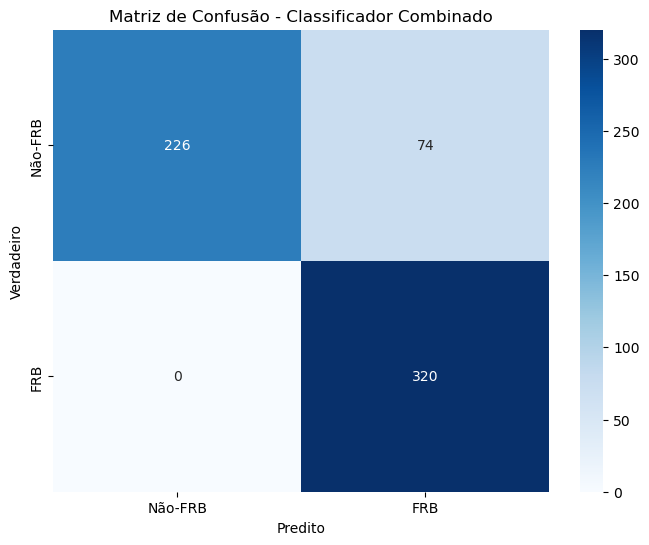

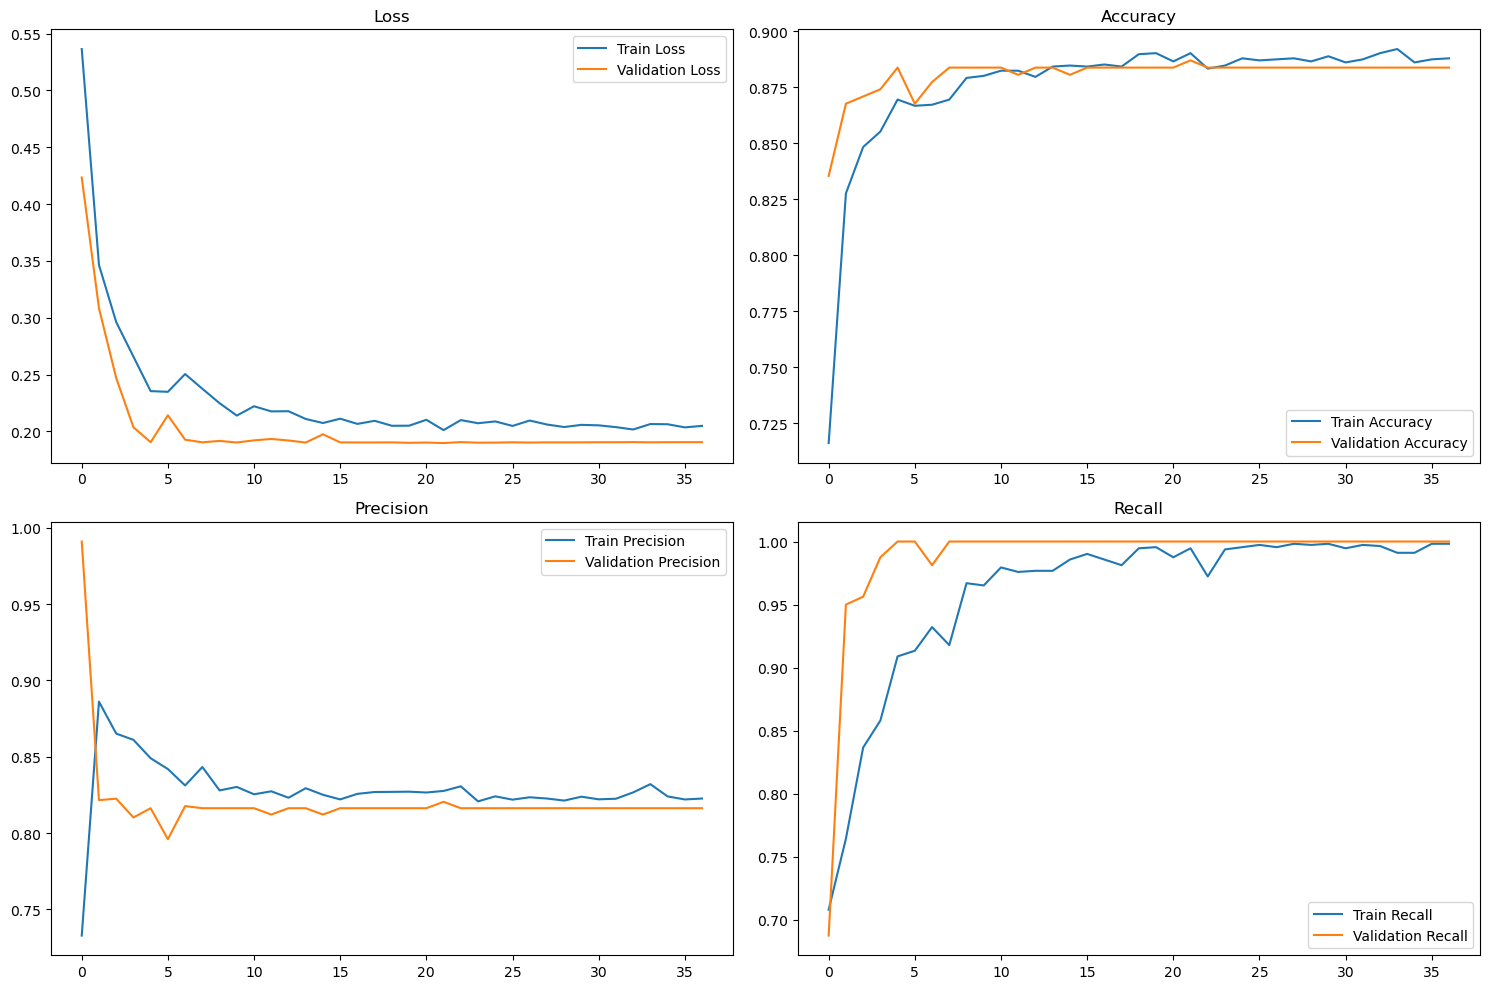


7. 💾 Salvando modelo treinado...
   ✅ Modelo salvo como 'frb_classifier_combined.h5'

✅ Pipeline completo executado com sucesso!
🎯 Acurácia final: 0.8806
📡 Dados CHIME usados: True
💾 Métricas salvas em 'pipeline_results.json'


In [84]:
def run_complete_pipeline(gan_samples=1000, chime_catalog_path='chimefrbcat1.fits', negative_samples=1500):
    """
    Pipeline completo: Gera dados da GAN, processa CHIME e treina classificador combinado
    
    Args:
        gan_samples: Número de séries para gerar com a GAN
        chime_catalog_path: Caminho para o catálogo CHIME (padrão: 'chimefrbcat1.fits')
        negative_samples: Número de amostras negativas para treino
    """
    print("INICIANDO PIPELINE COMPLETO")
    print(f"Catálogo CHIME: {chime_catalog_path}")
    print(f"Amostras GAN: {gan_samples}")
    
    # GERAR DADOS DA GAN
    print("Gerando dados sintéticos com GAN...")
    filename_gan, gen_df = generate_and_save_fits_with_timeseries_v2(
        n_samples=gan_samples,
        filename='synthetic_frbs.fits'
    )
    print(f"GAN: {gan_samples} séries salvas em {filename_gan}")
    
    # PROCESSAR DADOS CHIME
    print(f"\nProcessando dados CHIME de {chime_catalog_path}...")
    try:
        filename_chime, chime_df, chime_series = generate_chime_timeseries_v2(
            chime_fits_path=chime_catalog_path,  # ← NOME CORRETO AQUI
            output_fits='chime_processed.fits'
        )
        print(f"CHIME: {len(chime_df)} séries processadas")
        chime_available = True
    except Exception as e:
        print(f"Erro ao processar CHIME: {e}")
        print("Continuando apenas com dados GAN...")
        filename_chime = None
        chime_df = None
        chime_available = False
    
    # CARREGAR E COMBINAR DADOS
    print("\nCarregando e combinando dados...")
    
    # Carregar dados GAN
    gan_series = load_universal_timeseries(filename_gan)
    X_gan = preprocess_timeseries_universal(gan_series)
    y_gan = np.ones(X_gan.shape[0])  # Label 1 = FRB
    
    # Carregar dados CHIME se disponíveis
    if chime_available:
        chime_loaded_series = load_universal_timeseries(filename_chime)
        X_chime = preprocess_timeseries_universal(chime_loaded_series)
        y_chime = np.ones(X_chime.shape[0])  # Label 1 = FRB
        
        # Combinar dados positivos (GAN + CHIME)
        X_positive = np.concatenate([X_gan, X_chime], axis=0)
        y_positive = np.concatenate([y_gan, y_chime], axis=0)
        print(f"Dados combinados: {X_positive.shape[0]} FRBs totais")
        print(f"GAN: {X_gan.shape[0]}, CHIME: {X_chime.shape[0]})")
    else:
        X_positive = X_gan
        y_positive = y_gan
        print("Usando apenas dados GAN")
    
    # PREPARAR DATASETS
    print("\nPreparando datasets para treinamento...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(
        X_positive, negative_samples
    )
    
    # TREINAR CLASSIFICADOR
    print("\nTreinando classificador LSTM...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    classifier = FRBClassifier(input_shape)
    
    history = classifier.train(X_train, y_train, X_val, y_val, 
                              epochs=100, batch_size=32)
    
    # AVALIAR MODELO
    print("\nAvaliando modelo...")
    test_loss, test_acc, test_precision, test_recall, test_auc = classifier.evaluate(X_test, y_test)
    
    print("\n" + "=" * 50)
    print("RESULTADOS FINAIS")

    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall:    {test_recall:.4f}")
    print(f"AUC:       {test_auc:.4f}")
    print(f"Loss:      {test_loss:.4f}")
    
    # Métricas detalhadas
    y_pred_proba = classifier.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Não-FRB', 'FRB']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não-FRB', 'FRB'], 
                yticklabels=['Não-FRB', 'FRB'])
    plt.title('Matriz de Confusão - Classificador Combinado')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()
    
    # Histórico de treinamento
    classifier.plot_training_history(history)
    
    # SALVAR MODELO
    print("\nSalvando modelo treinado...")
    classifier.model.save('frb_classifier_combined.h5')
    print("Modelo salvo como 'frb_classifier_combined.h5'")
    
    return {
        'classifier': classifier,
        'history': history,
        'gan_filename': filename_gan,
        'chime_filename': filename_chime if chime_available else None,
        'chime_available': chime_available,
        'test_metrics': {
            'accuracy': test_acc,
            'precision': test_precision,
            'recall': test_recall,
            'auc': test_auc,
            'loss': test_loss
        }
    }

# EXECUTAR O PIPELINE COMPLETO
if __name__ == "__main__":
    print("PIPELINE COMPLETO - GAN + CHIME + LSTM")
    
    # Executar pipeline com nome correto do CHIME
    results = run_complete_pipeline(
        gan_samples=1000,
        chime_catalog_path='chimefrbcat1.fits',  
        negative_samples=1500
    )
    
    print("\nPipeline completo executado com sucesso!")
    print(f"Acurácia final: {results['test_metrics']['accuracy']:.4f}")
    print(f"Dados CHIME usados: {results['chime_available']}")
    
    # Salvar metadados dos resultados
    import json
    with open('pipeline_results.json', 'w') as f:
        json.dump(results['test_metrics'], f, indent=2)
    print("Métricas salvas em 'pipeline_results.json'")

# Rede Siamesa e Few Shot Learning

Distribuição original das classes: [222 130  58  80  10]
Distribuição após aumento da classe 4: [222 130  58  80  90]
Class weights calculados: {np.int64(0): np.float64(0.5238709677419355), np.int64(1): np.float64(0.8923076923076924), np.int64(2): np.float64(1.9804878048780488), np.int64(3): np.float64(1.45), np.int64(4): np.float64(1.288888888888889)}
Epoch 1/100


/Users/rafas/opt/anaconda3/envs/tf_py310/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5229 - loss: 0.5163 - precision_20: 0.0802 - recall_20: 0.0039 - val_accuracy: 0.5183 - val_loss: 0.6924 - val_precision_20: 0.5183 - val_recall_20: 1.0000
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4951 - loss: 0.4837 - precision_20: 0.4951 - recall_20: 1.0000 - val_accuracy: 0.5183 - val_loss: 0.6976 - val_precision_20: 0.5183 - val_recall_20: 1.0000
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4908 - loss: 0.4732 - precision_20: 0.4908 - recall_20: 1.0000 - val_accuracy: 0.5183 - val_loss: 0.6996 - val_precision_20: 0.5183 - val_recall_20: 1.0000
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4943 - loss: 0.4692 - precision_20: 0.4943 - recall_20: 1.0000 - val_accuracy: 0.5183 - val_loss: 0.7018 - val_precision_20: 0.5183 - val_recall_20: 1.0000
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4808 - loss: 0.4668 - precision_20: 0.4808 - recall_2

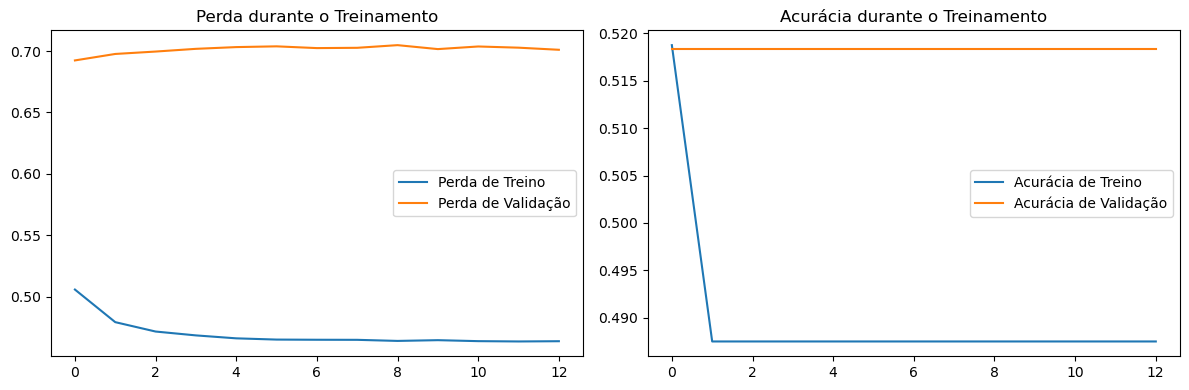

Acurácia na classificação few-shot: 47.70%

MÉTRICAS DETALHADAS - COM FOCO NA CLASSE 4
Matriz de Confusão:
[[22  3  8 10 24]
 [ 4 18  1  5 11]
 [ 0  1 12  4  0]
 [ 3  1  2 13  5]
 [ 4  0  0  5 18]]


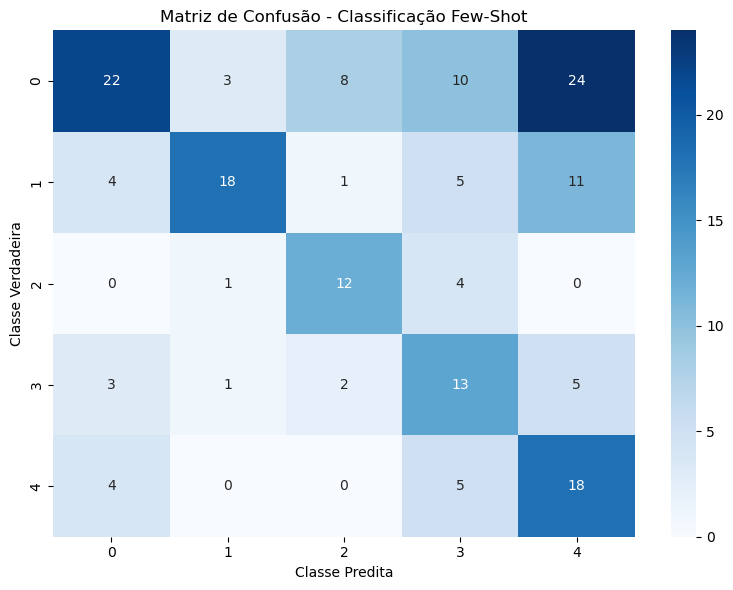


RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

    Classe 0       0.67      0.33      0.44        67
    Classe 1       0.78      0.46      0.58        39
    Classe 2       0.52      0.71      0.60        17
    Classe 3       0.35      0.54      0.43        24
    Classe 4       0.31      0.67      0.42        27

    accuracy                           0.48       174
   macro avg       0.53      0.54      0.49       174
weighted avg       0.58      0.48      0.48       174


MÉTRICAS ESPECÍFICAS - CLASSE 4:
Precision: 0.310
Recall: 0.667
F1-Score: 0.424


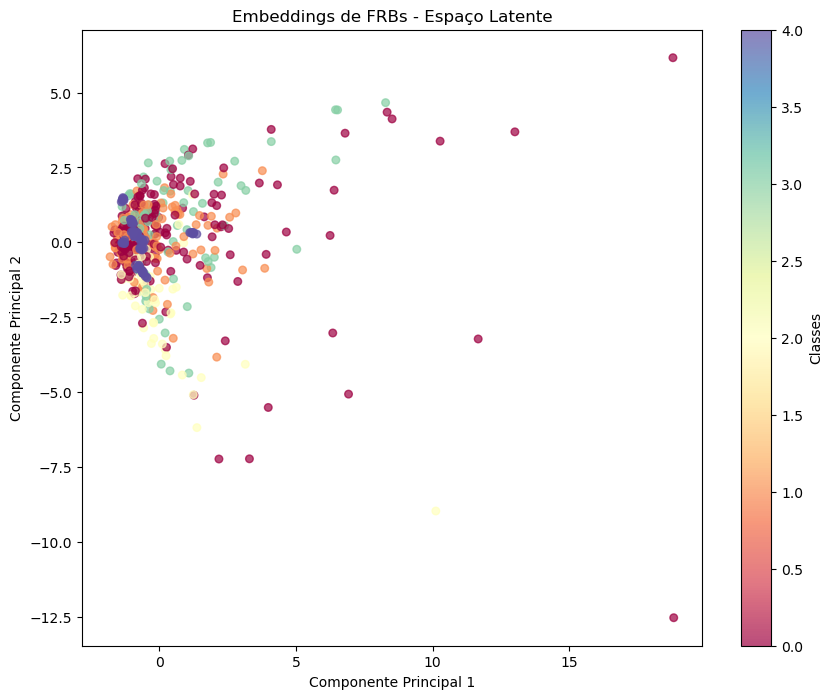

In [119]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# Configuração de parâmetros
BATCH_SIZE = 32
EMBEDDING_DIM = 64
EPOCHS = 100
VALIDATION_SPLIT = 0.2

# FUNÇÕES DE MELHORIA PARA CLASSES DESBALANCEADAS
def augmentar_classe_minoritaria(X, y, classe_alvo, factor=5):
    
    # Aumenta artificialmente os exemplos de uma classe minoritária
    indices_classe = np.where(y == classe_alvo)[0]
    if len(indices_classe) == 0:
        return X, y
    
    X_classe = X[indices_classe]
    
    # Gerar amostras sintéticas com ruído gaussiano controlado
    amostras_sinteticas = []
    for _ in range(factor):
        # Ruído proporcional ao desvio padrão de cada feature
        ruido = np.random.normal(0, 0.05, X_classe.shape) * np.std(X_classe, axis=0)
        amostras_sinteticas.append(X_classe + ruido)
    
    X_aumentado = np.vstack([X] + amostras_sinteticas)
    y_aumentado = np.hstack([y] + [np.full(len(X_classe), classe_alvo) for _ in range(factor)])
    
    return X_aumentado, y_aumentado

def calcular_class_weights(y):
    
    # Calcula pesos para classes desbalanceadas
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    return dict(zip(classes, class_weights))

def criar_pares_siameses_balanceados(X, y, num_pares=5000, classe_ponderada=None, peso_extra=3.0):
    
    # Cria pares siameses com sobre-amostragem para classes minoritárias
    pares = []
    rotulos = []
    classes = np.unique(y)
    class_indices = [np.where(y == i)[0] for i in classes]
    
    for _ in range(num_pares):
        # Aumentar probabilidade de pares envolvendo a classe minoritária
        if classe_ponderada is not None and np.random.random() < 0.4:  # 40% de chance
            classe1 = classe_ponderada
            if len(class_indices[classe1]) < 1:
                continue
                
            if np.random.random() > 0.5:
                # Par positivo com classe ponderada
                if len(class_indices[classe1]) >= 2:
                    idx1, idx2 = np.random.choice(class_indices[classe1], 2, replace=False)
                    pares.append([X[idx1], X[idx2]])
                    rotulos.append(1.0)
                else:
                    # Se não há amostras suficientes, cria par com ela mesma
                    idx1 = np.random.choice(class_indices[classe1])
                    idx2 = idx1  # Mesma amostra (ainda assim útil para learning)
                    pares.append([X[idx1], X[idx2]])
                    rotulos.append(1.0)
            else:
                # Par negativo com classe ponderada
                outras_classes = [c for c in classes if c != classe1 and len(class_indices[c]) > 0]
                if outras_classes:
                    classe2 = np.random.choice(outras_classes)
                    idx1 = np.random.choice(class_indices[classe1])
                    idx2 = np.random.choice(class_indices[classe2])
                    pares.append([X[idx1], X[idx2]])
                    rotulos.append(0.0)
        else:
            # Par normal
            if np.random.random() > 0.5:
                classe = np.random.choice(classes)
                if len(class_indices[classe]) < 2:
                    continue
                idx1, idx2 = np.random.choice(class_indices[classe], 2, replace=False)
                pares.append([X[idx1], X[idx2]])
                rotulos.append(1.0)
            else:
                classes_disponiveis = [c for c in classes if len(class_indices[c]) > 0]
                if len(classes_disponiveis) < 2:
                    continue
                classe1, classe2 = np.random.choice(classes_disponiveis, 2, replace=False)
                idx1 = np.random.choice(class_indices[classe1])
                idx2 = np.random.choice(class_indices[classe2])
                pares.append([X[idx1], X[idx2]])
                rotulos.append(0.0)
                
    return np.array(pares), np.array(rotulos)

# FUNÇÕES ORIGINAIS COM MELHORIAS

# Carregar dados do catálogo CHIME/FRB
def carregar_dados_chime(caminho_arquivo):
    with fits.open(caminho_arquivo) as hdul:
        dados = hdul[1].data
        df = pd.DataFrame(dados)
    return df

# Cria dados simulados
def criar_dados_simulados_chime(num_amostras=500):
    np.random.seed(42)
    
    dados = {
        'dm': np.random.exponential(400, num_amostras) + 100,
        'width': np.random.lognormal(0.5, 1.2, num_amostras),
        'snr': np.random.exponential(15, num_amostras) + 5,
        'flux': np.random.exponential(2, num_amostras) + 0.1,
        'scat': np.random.lognormal(-1, 1.5, num_amostras),
        'bandwidth': np.random.uniform(200, 400, num_amostras)
    }
    
    dados['dm_width_ratio'] = dados['dm'] / dados['width']
    dados['flux_snr_ratio'] = dados['flux'] / dados['snr']
    
    X = np.column_stack([dados['dm'], dados['width'], dados['snr'], 
                         dados['flux'], dados['scat'], dados['bandwidth'],
                         dados['dm_width_ratio'], dados['flux_snr_ratio']])
    
    y = np.zeros(num_amostras)
    y[(dados['dm'] > 500) & (dados['width'] < 10)] = 1
    y[(dados['dm'] < 300) & (dados['snr'] > 20)] = 2
    y[(dados['flux'] > 2.5) & (dados['scat'] < 0.5)] = 3
    
    indices_raros = np.random.choice(num_amostras, 10, replace=False)
    y[indices_raros] = 4
    
    return X, y, dados

# Criar dados simulados
X, y, dados_simulados = criar_dados_simulados_chime(500)

# Pré-processamento dos dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# APLICAR DATA AUGMENTATION PARA CLASSE 4
print("Distribuição original das classes:", np.bincount(y_encoded))

# Aumentar apenas a classe 4 (a minoritária)
X_aumentado, y_aumentado = augmentar_classe_minoritaria(X_normalized, y_encoded, 
                                                       classe_alvo=4, factor=8)

print("Distribuição após aumento da classe 4:", np.bincount(y_aumentado))

X_normalized = X_aumentado
y_encoded = y_aumentado

# Divisão em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Calcular class weights para balanceamento
class_weights = calcular_class_weights(y_train)
print("Class weights calculados:", class_weights)

# Criar pares balanceados com foco na classe 4
pares_treino, rotulos_treino = criar_pares_siameses_balanceados(
    X_train, y_train, 
    num_pares=6000,  # Mais pares para melhor aprendizado
    classe_ponderada=4,  # Foco na classe 4
    peso_extra=5.0
)

pares_teste, rotulos_teste = criar_pares_siameses_balanceados(
    X_test, y_test, 
    num_pares=1500,
    classe_ponderada=4,
    peso_extra=3.0
)

# Definir a rede de base (encoder)
def criar_rede_base(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(EMBEDDING_DIM, activation='linear')
    ])
    return model

# Definir a rede siamesa
def criar_rede_siamesa(input_shape):
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    
    base_network = criar_rede_base(input_shape)
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = layers.Lambda(
        lambda tensors: tf.math.sqrt(
            tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)
        )
    )([processed_a, processed_b])
    
    output = layers.Dense(1, activation='sigmoid')(distance)
    model = keras.Model(inputs=[input_a, input_b], outputs=output)
    return model

# Criar e compilar o modelo
input_shape = (X_train.shape[1],)
siamese_network = criar_rede_siamesa(input_shape)
siamese_network.compile(
    optimizer=keras.optimizers.Adam(0.0003),  # Learning rate menor
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callback para early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=12, restore_best_weights=True
)

# Treinar o modelo COM CLASS WEIGHTS
history = siamese_network.fit(
    [pares_treino[:, 0], pares_treino[:, 1]],
    rotulos_treino,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping],
    verbose=1,
    class_weight=class_weights  # PESOS PARA CLASSES DESBALANCEADAS
)

# Avaliar o modelo
loss, accuracy, precision, recall = siamese_network.evaluate(
    [pares_teste[:, 0], pares_teste[:, 1]],
    rotulos_teste
)
print(f"Acurácia no conjunto de teste: {accuracy*100:.2f}%")
print(f"Precisão: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

# Visualizar o progresso do treinamento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.legend()
plt.tight_layout()
plt.show()

# Extrair a rede de embedding
rede_embedding = criar_rede_base(input_shape)
rede_embedding.set_weights(siamese_network.layers[2].get_weights())

# Função para classificação few-shot
def classificar_few_shot(novos_exemplos, exemplos_referencia, classes_referencia, k=3):
    
    # Classifica novos exemplos usando abordagem few-shot
    embeddings_ref = []
    classes_ref_expandidas = []
    
    for classe, exemplos in zip(classes_referencia, exemplos_referencia):
        if len(exemplos) > 0:
            emb = rede_embedding.predict(exemplos, verbose=0)
            embeddings_ref.extend(emb)
            classes_ref_expandidas.extend([classe] * len(exemplos))
    
    embeddings_ref = np.array(embeddings_ref)
    classes_ref_expandidas = np.array(classes_ref_expandidas)
    
    embeddings_novos = rede_embedding.predict(novos_exemplos, verbose=0)
    
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(embeddings_ref, classes_ref_expandidas)
    
    return knn.predict(embeddings_novos)

# Preparar exemplos de referência
exemplos_por_classe = []
classes_unicas = np.unique(y_train)

for classe in classes_unicas:
    indices_classe = np.where(y_train == classe)[0]
    n_exemplos = min(8, len(indices_classe))
    exemplos_referencia = X_train[np.random.choice(indices_classe, n_exemplos, replace=False)]
    exemplos_por_classe.append(exemplos_referencia)

# Classificar os exemplos de teste
previsoes = classificar_few_shot(X_test, exemplos_por_classe, classes_unicas, k=3)

# Calcular acurácia
acuracia = np.mean(previsoes == y_test)
print(f"Acurácia na classificação few-shot: {acuracia*100:.2f}%")

# MÉTRICAS DETALHADAS COM FOCO NA CLASSE 4
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

print("\n" + "="*60)
print("MÉTRICAS DETALHADAS - COM FOCO NA CLASSE 4")
print("="*60)

# Matriz de Confusão
cm = confusion_matrix(y_test, previsoes)
print("Matriz de Confusão:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes_unicas, 
            yticklabels=classes_unicas)
plt.title('Matriz de Confusão - Classificação Few-Shot')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Relatório de Classificação Detalhado
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, previsoes, 
                           target_names=[f'Classe {i}' for i in classes_unicas]))

# Métricas específicas para a Classe 4
classe_4_idx = np.where(classes_unicas == 4)[0]
if len(classe_4_idx) > 0:
    classe_4_idx = classe_4_idx[0]
    precision_4 = precision_score(y_test, previsoes, labels=[4], average='micro', zero_division=0)
    recall_4 = recall_score(y_test, previsoes, labels=[4], average='micro', zero_division=0)
    f1_4 = f1_score(y_test, previsoes, labels=[4], average='micro', zero_division=0)
    
    print(f"\nMÉTRICAS ESPECÍFICAS - CLASSE 4:")
    print(f"Precision: {precision_4:.3f}")
    print(f"Recall: {recall_4:.3f}")
    print(f"F1-Score: {f1_4:.3f}")

# Visualizar embeddings
def visualizar_embeddings(X, y, titulo="Embeddings de FRBs"):
    from sklearn.decomposition import PCA
    reducer = PCA(n_components=2)
    embedding_2d = reducer.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], 
                         c=y, cmap='Spectral', s=30, alpha=0.7)
    plt.colorbar(scatter, label='Classes')
    plt.title(titulo)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

all_embeddings = rede_embedding.predict(X_normalized, verbose=0)
visualizar_embeddings(all_embeddings, y_encoded, "Embeddings de FRBs - Espaço Latente")

Distribuição original das classes: [222 130  58  80  10]
Distribuição após aumento da classe 4: [222 130  58  80  70]
Class weights calculados: {np.int64(0): np.float64(0.5058064516129033), np.int64(1): np.float64(0.8615384615384616), np.int64(2): np.float64(1.9121951219512194), np.int64(3): np.float64(1.4), np.int64(4): np.float64(1.6)}
Epoch 1/100


/Users/rafas/opt/anaconda3/envs/tf_py310/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5191 - loss: 0.8955 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_accuracy: 0.5360 - val_loss: 0.7457 - val_precision_24: 1.0000 - val_recall_24: 0.0232 - learning_rate: 2.0000e-04 - lr: 2.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5013 - loss: 0.7567 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_accuracy: 0.5410 - val_loss: 0.7479 - val_precision_24: 1.0000 - val_recall_24: 0.0337 - learning_rate: 2.0000e-04 - lr: 2.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5010 - loss: 0.6659 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_accuracy: 0.5480 - val_loss: 0.7369 - val_precision_24: 1.0000 - val_recall_24: 0.0484 - learning_rate: 2.0000e-04 - lr: 2.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5260 - loss: 0.5971 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_accuracy: 0.5480 - val_loss: 0.7307 - va

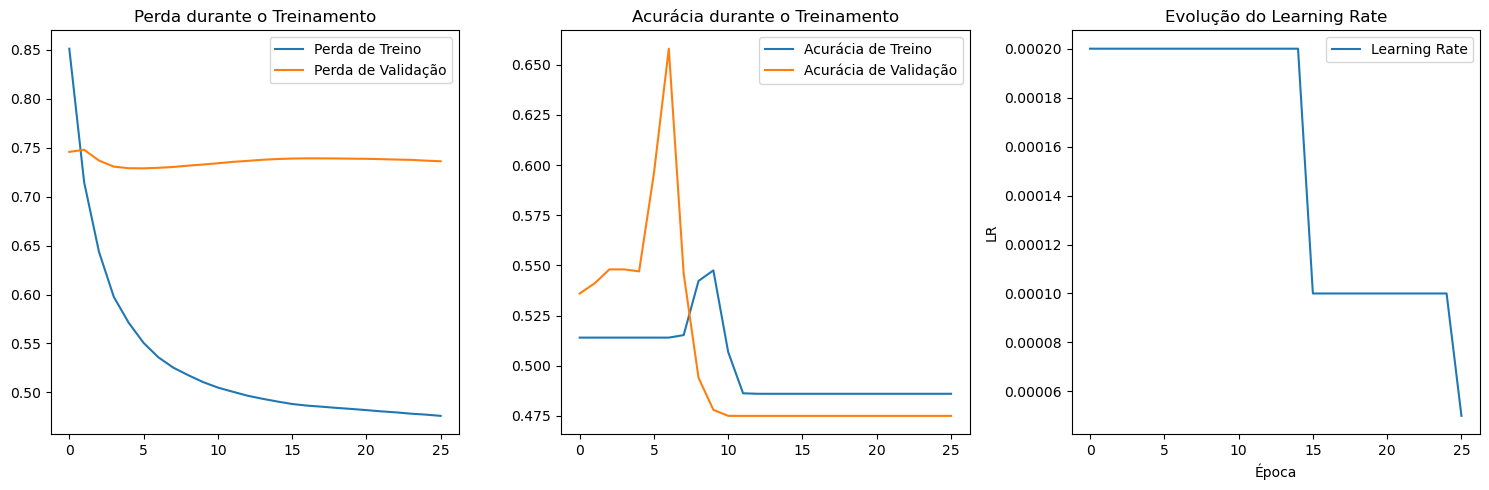

Acurácia na classificação few-shot: 47.02%

MÉTRICAS DETALHADAS - COM FOCO NA CLASSE 4
Matriz de Confusão:
[[33  2  9  7 16]
 [ 7 17  5  3  7]
 [ 2  0  6  9  0]
 [ 6  2  6  7  3]
 [ 2  0  3  0 16]]


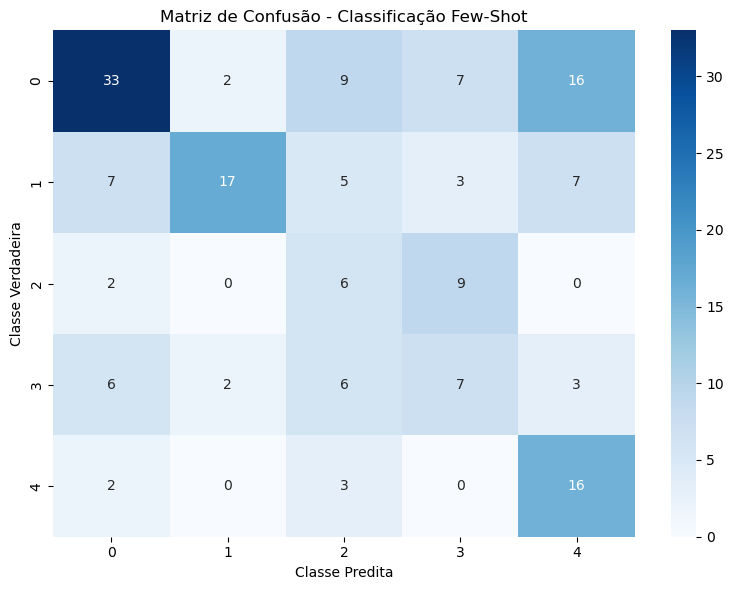


RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

    Classe 0       0.66      0.49      0.56        67
    Classe 1       0.81      0.44      0.57        39
    Classe 2       0.21      0.35      0.26        17
    Classe 3       0.27      0.29      0.28        24
    Classe 4       0.38      0.76      0.51        21

    accuracy                           0.47       168
   macro avg       0.47      0.47      0.44       168
weighted avg       0.56      0.47      0.49       168


MÉTRICAS ESPECÍFICAS - CLASSE 4:
Precision: 0.381
Recall: 0.762
F1-Score: 0.508

ANÁLISE DE SIMILARIDADE ENTRE CLASSES
Distância média Classe 0 - Classe 1: 3.7870
Distância média Classe 0 - Classe 2: 3.7087
Distância média Classe 0 - Classe 3: 4.1070
Distância média Classe 0 - Classe 4: 2.9689
Distância média Classe 1 - Classe 2: 4.0393
Distância média Classe 1 - Classe 3: 4.1993
Distância média Classe 1 - Classe 4: 3.0519
Distância média Classe 2 - Classe 3: 4.2387
Distância 

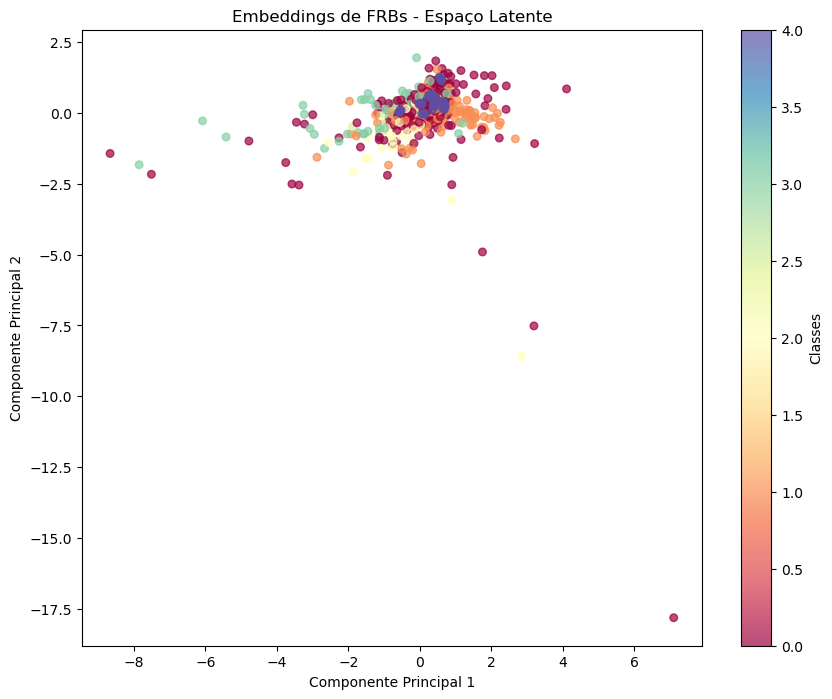

In [123]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# Configuração de parâmetros
BATCH_SIZE = 32
EMBEDDING_DIM = 64
EPOCHS = 100
VALIDATION_SPLIT = 0.2

# CALLBACK PARA REGISTRAR LEARNING RATE
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        logs['lr'] = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

# FUNÇÕES DE MELHORIA PARA CLASSES DESBALANCEADAS (OTIMIZADAS)
def augmentar_classe_minoritaria(X, y, classe_alvo, factor=6):  # Aumentado de 4 para 6
    """
    Aumenta artificialmente os exemplos de uma classe minoritária
    """
    indices_classe = np.where(y == classe_alvo)[0]
    if len(indices_classe) == 0:
        return X, y
    
    X_classe = X[indices_classe]
    
    # Gerar amostras sintéticas com ruído gaussiano controlado
    amostras_sinteticas = []
    for _ in range(factor):
        # Ruído balanceado
        ruido = np.random.normal(0, 0.04, X_classe.shape) * np.std(X_classe, axis=0)
        amostras_sinteticas.append(X_classe + ruido)
    
    X_aumentado = np.vstack([X] + amostras_sinteticas)
    y_aumentado = np.hstack([y] + [np.full(len(X_classe), classe_alvo) for _ in range(factor)])
    
    return X_aumentado, y_aumentado

def calcular_class_weights(y):
    
    # Calcula pesos para classes desbalanceadas
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    return dict(zip(classes, class_weights))

def criar_pares_siameses_balanceados(X, y, num_pares=5000, classe_ponderada=None, peso_extra=3.0):  # Aumentado de 2.0 para 3.0
    
    # Cria pares siameses com sobre-amostragem para classes minoritárias
    pares = []
    rotulos = []
    classes = np.unique(y)
    class_indices = [np.where(y == i)[0] for i in classes]
    
    for _ in range(num_pares):
        # Probabilidade balanceada para classe minoritária (30%)
        if classe_ponderada is not None and np.random.random() < 0.30:
            classe1 = classe_ponderada
            if len(class_indices[classe1]) < 1:
                continue
                
            if np.random.random() > 0.55:  # Balanceado entre positivos e negativos
                # Par positivo com classe ponderada
                if len(class_indices[classe1]) >= 2:
                    idx1, idx2 = np.random.choice(class_indices[classe1], 2, replace=False)
                    pares.append([X[idx1], X[idx2]])
                    rotulos.append(1.0)
                else:
                    # Usar mesma amostra para par positivo
                    idx1 = np.random.choice(class_indices[classe1])
                    pares.append([X[idx1], X[idx1]])
                    rotulos.append(1.0)
            else:
                # Par negativo com classe ponderada
                outras_classes = [c for c in classes if c != classe1 and len(class_indices[c]) > 0]
                if outras_classes:
                    classe2 = np.random.choice(outras_classes)
                    idx1 = np.random.choice(class_indices[classe1])
                    idx2 = np.random.choice(class_indices[classe2])
                    pares.append([X[idx1], X[idx2]])
                    rotulos.append(0.0)
        else:
            # Par normal
            if np.random.random() > 0.5:
                classe = np.random.choice(classes)
                if len(class_indices[classe]) < 2:
                    continue
                idx1, idx2 = np.random.choice(class_indices[classe], 2, replace=False)
                pares.append([X[idx1], X[idx2]])
                rotulos.append(1.0)
            else:
                classes_disponiveis = [c for c in classes if len(class_indices[c]) > 0]
                if len(classes_disponiveis) < 2:
                    continue
                classe1, classe2 = np.random.choice(classes_disponiveis, 2, replace=False)
                idx1 = np.random.choice(class_indices[classe1])
                idx2 = np.random.choice(class_indices[classe2])
                pares.append([X[idx1], X[idx2]])
                rotulos.append(0.0)
                
    return np.array(pares), np.array(rotulos)

# Carregar dados do catálogo CHIME/FRB
def carregar_dados_chime(caminho_arquivo):
    with fits.open(caminho_arquivo) as hdul:
        dados = hdul[1].data
        df = pd.DataFrame(dados)
    return df

# Cria dados simulados
def criar_dados_simulados_chime(num_amostras=500):
    np.random.seed(42)
    
    dados = {
        'dm': np.random.exponential(400, num_amostras) + 100,
        'width': np.random.lognormal(0.5, 1.2, num_amostras),
        'snr': np.random.exponential(15, num_amostras) + 5,
        'flux': np.random.exponential(2, num_amostras) + 0.1,
        'scat': np.random.lognormal(-1, 1.5, num_amostras),
        'bandwidth': np.random.uniform(200, 400, num_amostras)
    }
    
    dados['dm_width_ratio'] = dados['dm'] / dados['width']
    dados['flux_snr_ratio'] = dados['flux'] / dados['snr']
    
    X = np.column_stack([dados['dm'], dados['width'], dados['snr'], 
                         dados['flux'], dados['scat'], dados['bandwidth'],
                         dados['dm_width_ratio'], dados['flux_snr_ratio']])
    
    y = np.zeros(num_amostras)
    y[(dados['dm'] > 500) & (dados['width'] < 10)] = 1
    y[(dados['dm'] < 300) & (dados['snr'] > 20)] = 2
    y[(dados['flux'] > 2.5) & (dados['scat'] < 0.5)] = 3
    
    indices_raros = np.random.choice(num_amostras, 10, replace=False)
    y[indices_raros] = 4
    
    return X, y, dados

# Criar dados simulados
X, y, dados_simulados = criar_dados_simulados_chime(500)

# Pré-processamento dos dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# APLICAR DATA AUGMENTATION PARA CLASSE 4 (OTIMIZADO)
print("Distribuição original das classes:", np.bincount(y_encoded))

# Aumentar apenas a classe 4 (factor aumentado de 4 para 6)
X_aumentado, y_aumentado = augmentar_classe_minoritaria(X_normalized, y_encoded, 
                                                       classe_alvo=4, factor=6)

print("Distribuição após aumento da classe 4:", np.bincount(y_aumentado))

X_normalized = X_aumentado
y_encoded = y_aumentado

# Divisão em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Calcular class weights para balanceamento
class_weights = calcular_class_weights(y_train)
print("Class weights calculados:", class_weights)

# Criar pares balanceados com foco na classe 4 (peso aumentado)
pares_treino, rotulos_treino = criar_pares_siameses_balanceados(
    X_train, y_train, 
    num_pares=5000,
    classe_ponderada=4,
    peso_extra=3.0  # Aumentado de 2.0 para 3.0
)

pares_teste, rotulos_teste = criar_pares_siameses_balanceados(
    X_test, y_test, 
    num_pares=1200,
    classe_ponderada=4,
    peso_extra=2.0  # Aumentado de 1.5 para 2.0
)

# ARQUITETURA DO MODELO COM REGULARIZAÇÃO OTIMIZADA

# Definir a rede de base (encoder) com regularização balanceada
def criar_rede_base(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape,
                    kernel_regularizer=keras.regularizers.l2(0.0005)),  # Reduzido de 0.001 para 0.0005
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Reduzido de 0.5 para 0.3
        layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.0005)),  # Reduzido de 0.001 para 0.0005
        layers.BatchNormalization(),
        layers.Dropout(0.25),  # Reduzido de 0.4 para 0.25
        layers.Dense(EMBEDDING_DIM, activation='linear')
    ])
    return model

# Definir a rede siamesa
def criar_rede_siamesa(input_shape):
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    
    base_network = criar_rede_base(input_shape)
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = layers.Lambda(
        lambda tensors: tf.math.sqrt(
            tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)
        )
    )([processed_a, processed_b])
    
    output = layers.Dense(1, activation='sigmoid')(distance)
    model = keras.Model(inputs=[input_a, input_b], outputs=output)
    return model

# Criar e compilar o modelo com learning rate ajustado
input_shape = (X_train.shape[1],)
siamese_network = criar_rede_siamesa(input_shape)
siamese_network.compile(
    optimizer=keras.optimizers.Adam(0.0002),  # Aumentado de 0.0001 para 0.0002
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callback para early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.0001  # Aumentado patience de 15 para 20
)

# Callback para reduzir learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7  # Aumentado patience de 8 para 10
)

lr_logger = LearningRateLogger()

# Treinar o modelo COM CLASS WEIGHTS
history = siamese_network.fit(
    [pares_treino[:, 0], pares_treino[:, 1]],
    rotulos_treino,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping, reduce_lr, lr_logger],
    verbose=1,
    class_weight=class_weights
)

# Avaliar o modelo
loss, accuracy, precision, recall = siamese_network.evaluate(
    [pares_teste[:, 0], pares_teste[:, 1]],
    rotulos_teste
)
print(f"Acurácia no conjunto de teste: {accuracy*100:.2f}%")
print(f"Precisão: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

# Visualizar o progresso do treinamento
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.legend()

plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Evolução do Learning Rate')
    plt.xlabel('Época')
    plt.ylabel('LR')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Learning Rate não registrado', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.title('Evolução do Learning Rate')
plt.tight_layout()
plt.show()

# Extrair a rede de embedding
rede_embedding = criar_rede_base(input_shape)
rede_embedding.set_weights(siamese_network.layers[2].get_weights())

# CLASSIFICAÇÃO FEW-SHOT COM THRESHOLD AJUSTÁVEL (OTIMIZADO)
def classificar_few_shot_com_threshold(novos_exemplos, exemplos_referencia, classes_referencia, k=3, threshold_classe_4=0.4):  # Reduzido threshold de 0.6 para 0.4
    
    # Classifica novos exemplos usando abordagem few-shot com threshold ajustável
    embeddings_ref = []
    classes_ref_expandidas = []
    
    for classe, exemplos in zip(classes_referencia, exemplos_referencia):
        if len(exemplos) > 0:
            emb = rede_embedding.predict(exemplos, verbose=0)
            embeddings_ref.extend(emb)
            classes_ref_expandidas.extend([classe] * len(exemplos))
    
    embeddings_ref = np.array(embeddings_ref)
    classes_ref_expandidas = np.array(classes_ref_expandidas)
    
    embeddings_novos = rede_embedding.predict(novos_exemplos, verbose=0)
    
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(embeddings_ref, classes_ref_expandidas)
    
    # Obter probabilidades
    probabilidades = knn.predict_proba(embeddings_novos)
    
    # Aplicar threshold - para classe 4, exigir confiança balanceada
    previsoes_ajustadas = []
    for prob in probabilidades:
        max_prob = np.max(prob)
        classe_predita = np.argmax(prob)
        
        # Threshold mais balanceado para classe 4
        if classe_predita == 4 and max_prob < threshold_classe_4:
            # Se não atingir threshold, usar segunda melhor classe
            prob_copy = prob.copy()
            prob_copy[4] = 0
            segunda_melhor_classe = np.argmax(prob_copy)
            segunda_melhor_prob = np.max(prob_copy)
            
            # Só mudar se a segunda melhor tiver probabilidade razoável
            if segunda_melhor_prob > 0.3:
                classe_predita = segunda_melhor_classe
        
        previsoes_ajustadas.append(classe_predita)
    
    return np.array(previsoes_ajustadas), probabilidades

# Preparar exemplos de referência
exemplos_por_classe = []
classes_unicas = np.unique(y_train)

for classe in classes_unicas:
    indices_classe = np.where(y_train == classe)[0]
    n_exemplos = min(6, len(indices_classe))
    exemplos_referencia = X_train[np.random.choice(indices_classe, n_exemplos, replace=False)]
    exemplos_por_classe.append(exemplos_referencia)

# Classificar os exemplos de teste com threshold ajustável
previsoes, probabilidades = classificar_few_shot_com_threshold(
    X_test, exemplos_por_classe, classes_unicas, k=3, threshold_classe_4=0.4  # Threshold mais baixo
)

# Calcular acurácia
acuracia = np.mean(previsoes == y_test)
print(f"Acurácia na classificação few-shot: {acuracia*100:.2f}%")

# MÉTRICAS DETALHADAS COM FOCO NA CLASSE 4
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

print("\n" + "="*60)
print("MÉTRICAS DETALHADAS - COM FOCO NA CLASSE 4")
print("="*60)

# Matriz de Confusão
cm = confusion_matrix(y_test, previsoes)
print("Matriz de Confusão:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes_unicas, 
            yticklabels=classes_unicas)
plt.title('Matriz de Confusão - Classificação Few-Shot')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Relatório de Classificação Detalhado
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, previsoes, 
                           target_names=[f'Classe {i}' for i in classes_unicas]))

# Métricas específicas para a Classe 4
if 4 in classes_unicas:
    precision_4 = precision_score(y_test, previsoes, labels=[4], average='micro', zero_division=0)
    recall_4 = recall_score(y_test, previsoes, labels=[4], average='micro', zero_division=0)
    f1_4 = f1_score(y_test, previsoes, labels=[4], average='micro', zero_division=0)
    
    print(f"\nMÉTRICAS ESPECÍFICAS - CLASSE 4:")
    print(f"Precision: {precision_4:.3f}")
    print(f"Recall: {recall_4:.3f}")
    print(f"F1-Score: {f1_4:.3f}")

# ANÁLISE DE SIMILARIDADE ENTRE CLASSES
print("\n" + "="*60)
print("ANÁLISE DE SIMILARIDADE ENTRE CLASSES")
print("="*60)

# Calcular distâncias médias entre embeddings de diferentes classes
embeddings_treino = rede_embedding.predict(X_train, verbose=0)

for i, classe1 in enumerate(classes_unicas):
    for j, classe2 in enumerate(classes_unicas):
        if i < j:  # Evitar duplicatas
            indices_classe1 = np.where(y_train == classe1)[0]
            indices_classe2 = np.where(y_train == classe2)[0]
            
            if len(indices_classe1) > 0 and len(indices_classe2) > 0:
                emb_classe1 = embeddings_treino[indices_classe1]
                emb_classe2 = embeddings_treino[indices_classe2]
                
                # Calcular distância média entre as classes
                distancias = []
                for emb1 in emb_classe1:
                    for emb2 in emb_classe2:
                        distancia = np.linalg.norm(emb1 - emb2)
                        distancias.append(distancia)
                
                dist_media = np.mean(distancias)
                print(f"Distância média Classe {classe1} - Classe {classe2}: {dist_media:.4f}")

# Visualizar embeddings
def visualizar_embeddings(X, y, titulo="Embeddings de FRBs"):
    from sklearn.decomposition import PCA
    reducer = PCA(n_components=2)
    embedding_2d = reducer.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], 
                         c=y, cmap='Spectral', s=30, alpha=0.7)
    plt.colorbar(scatter, label='Classes')
    plt.title(titulo)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

all_embeddings = rede_embedding.predict(X_normalized, verbose=0)
visualizar_embeddings(all_embeddings, y_encoded, "Embeddings de FRBs - Espaço Latente")